In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#plt.rcParams.update({'figure.autolayout': True})

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import os
import umap

import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus

from sklearn.cross_decomposition import CCA
import scipy as sp


In [2]:
#path2dir = 'data_processing_feb2020/abstracts_2018_200k/'
path2dir = 'data_processing_feb2020/abstracts_2018_200k_win2/'
#path2dir = 'data_processing_feb2020/titles_2018_250k/'
#path2dir = 'data_processing_feb2020/titles_2018_500k/'

N_samples = 3

In [3]:
### organize list of w2v models

In [4]:
files_list = [f for f in os.listdir(path2dir) if '.model' in f]
w2v_names = []
 
for i_sample in range(N_samples):
    
    sample_models = [f for f in files_list if '{}_cluster'.format(i_sample) in f]
    N_communities = len(sample_models)
    print("{} communities in sample {}".format(N_communities, i_sample))
    
    w2v_names.append([])
    for i_community in range(N_communities):
        
        for j_path in sample_models:
            if 'cluster{}'.format(i_community) in j_path:
                this_path = j_path
        w2v_names[i_sample].append(this_path)
        print(w2v_names[i_sample][i_community])
    
    print()

#  WARNING   assumes communities are matched across samples
#        in number and identity.
#    if this condition does not hold, don't use this analysis

9 communities in sample 0
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

9 communities in sample 1
abstracts_1_cluster0_2018_200k_win2.model
abstracts_1_cluster1_2018_200k_win2.model
abstracts_1_cluster2_2018_200k_win2.model
abstracts_1_cluster3_2018_200k_win2.model
abstracts_1_cluster4_2018_200k_win2.model
abstracts_1_cluster5_2018_200k_win2.model
abstracts_1_cluster6_2018_200k_win2.model
abstracts_1_cluster7_2018_200k_win2.model
abstracts_1_cluster8_2018_200k_win2.model

9 communities in sample 2
abstracts_2_cluster0_2018_200k_win2.model
abstracts_2_cluster1_2018_200k_win2.model
abstracts_2_cluster2_2018_200k_win2.model
abstracts_2_cluster3_2018_200k_win2.mo

In [5]:
### helper functions for CCA

In [6]:
def load_model(path2model):
    model = Word2Vec.load(path2model)
    print('{} words '.format(len(model.wv.vocab)))
    return model

In [7]:
def get_shared_vocabulary(modelA, modelB):
    
    vocabA = set(modelA.wv.vocab)
    vocabB = set(modelB.wv.vocab)
    shared_vocab = vocabA.intersection(vocabB)
    shared_vocab = list(shared_vocab)
    
    print("size of shared vocabulary: {}".format(len(shared_vocab)))
    return shared_vocab

In [8]:
def build_sample_matrix(model, vocab_subset, doPlot=True):
    
    D = model.trainables.layer1_size
    samples = np.zeros((len(vocab_subset), D))
    
    for i_word, word in enumerate(vocab_subset):
        samples[i_word,:] = model.wv[word]
        
    # demean
    # todo think more about this
    '''
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
    '''
    
    if doPlot:
        min_val = np.min(samples.flatten())
        max_val = np.min(samples.flatten())
        extrema = np.max([abs(min_val), max_val])
        v_min, v_max = -extrema, extrema
        
        plt.figure()
        plt.imshow(samples,
                   origin='lower',
                   extent=[0, D, 0, len(vocab_subset)],
                   aspect= D / len(vocab_subset),
                   vmin = v_min,
                   vmax = v_max,
                   cmap='Spectral')
        plt.colorbar()
        plt.title('sample (original coordinates)')
        plt.xlabel('dimension')
        plt.ylabel('shared word index')
    
    return samples

In [9]:
def run_cca(U, V, N_components=3, doPlot=True):
    
    cca = CCA(n_components=N_components)
    cca.fit(U, V)
    U_c, V_c = cca.transform(U, V)
    cc_corr = np.corrcoef(cca.x_scores_,
                          cca.y_scores_,
                          rowvar=False).diagonal(offset=cca.n_components)
    
    if doPlot:
        plt.figure(figsize=(2,2))
        plt.plot(cc_corr)
        plt.ylim([0,1])
        plt.title('canonical correlations (data)')
        plt.ylabel('correlation coefficient')
        plt.xlabel('canonical component')
        
    return U_c, V_c, cc_corr

In [10]:
def plot_word_similarity(U_c, V_c, shared_vocabulary, doSave=False):
    
    similarities = []
    for i_word, word in enumerate(shared_vocabulary):    
        score = 1 - sp.spatial.distance.cosine(U_c[i_word], V_c[i_word])
        similarities.append(score) 
        
    plt.figure(figsize=(3,3))
    plt.hist(similarities, histtype='step', bins=50, density=True)
    plt.title('aligned word similarities (cosine)')
    plt.xlabel('cosine similarity score (word i in context U vs V)')
    plt.ylabel('probability density')
    
    if doSave:
        plt.savefig(path2dir + 'same_community_cca_wordsimilarities.png')
        plt.savefig(path2dir + 'same_community_cca_wordsimilarities.pdf')
        
    return similarities

In [11]:
### perform the alignment (same community, different sample)

abstracts_0_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster0_2018_200k_win2.model
2236 words 

abstracts_1_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster0_2018_200k_win2.model
2209 words 

abstracts_2_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster0_2018_200k_win2.model
2229 words 

size of shared vocabulary: 2114
size of shared vocabulary: 2136
size of shared vocabulary: 2117
abstracts_0_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster1_2018_200k_win2.model
2201 words 

abstracts_1_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster1_2018_200k_win2.model
2188 words 

abstracts_2_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster1_2018_200k_win2.model
2141 words 

size of shared vocabulary: 2

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


size of shared vocabulary: 2036
abstracts_0_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster2_2018_200k_win2.model
2545 words 

abstracts_1_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster2_2018_200k_win2.model
2527 words 

abstracts_2_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster2_2018_200k_win2.model
2522 words 

size of shared vocabulary: 2313
size of shared vocabulary: 2270


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


size of shared vocabulary: 2301
abstracts_0_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster3_2018_200k_win2.model
2370 words 

abstracts_1_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster3_2018_200k_win2.model
2415 words 

abstracts_2_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster3_2018_200k_win2.model
2411 words 

size of shared vocabulary: 2128
size of shared vocabulary: 2122
size of shared vocabulary: 2148
abstracts_0_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster4_2018_200k_win2.model
2565 words 

abstracts_1_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster4_2018_200k_win2.model
2575 words 

abstracts_2_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster4_2018_200k_win2.model
2504 word

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


size of shared vocabulary: 2231


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


abstracts_0_cluster7_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster7_2018_200k_win2.model
1974 words 

abstracts_1_cluster7_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster7_2018_200k_win2.model
1981 words 

abstracts_2_cluster7_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster7_2018_200k_win2.model
2007 words 

size of shared vocabulary: 1810


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1830


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1817


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


abstracts_0_cluster8_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster8_2018_200k_win2.model
2245 words 

abstracts_1_cluster8_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster8_2018_200k_win2.model
2194 words 

abstracts_2_cluster8_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster8_2018_200k_win2.model
2132 words 

size of shared vocabulary: 1929


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1907


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1894


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


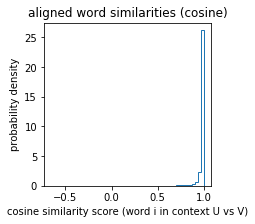

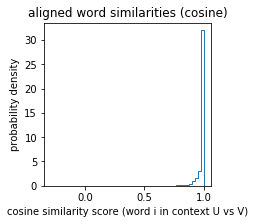

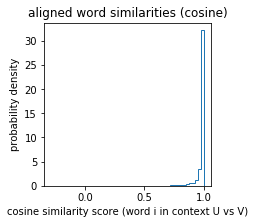

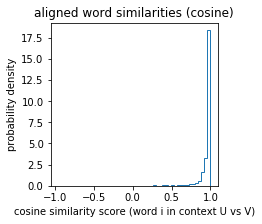

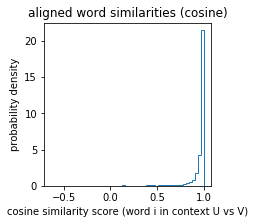

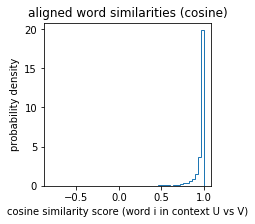

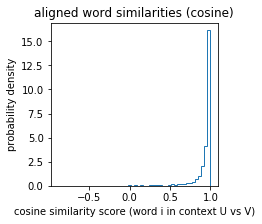

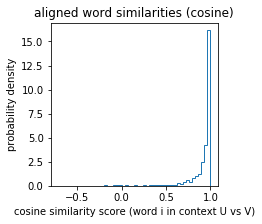

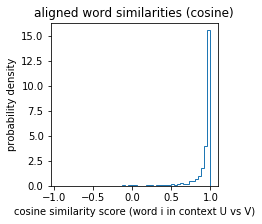

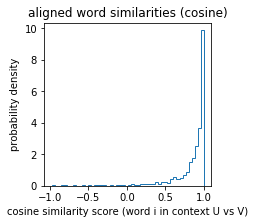

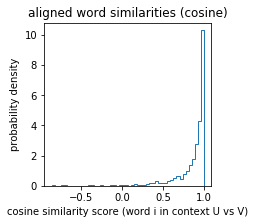

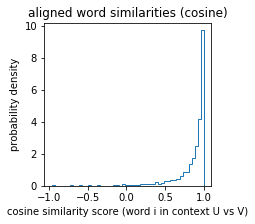

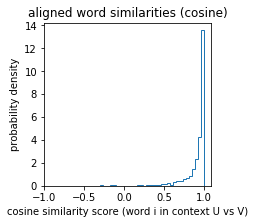

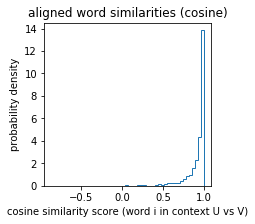

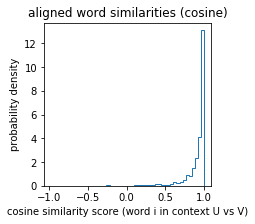

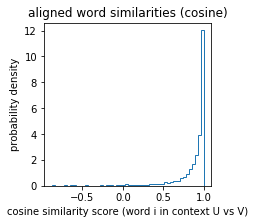

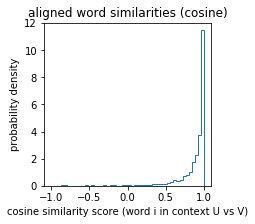

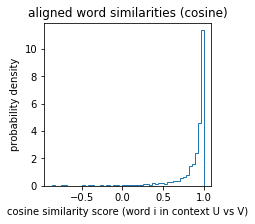

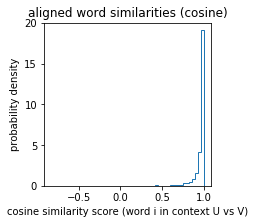

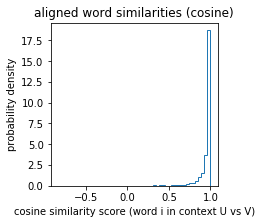

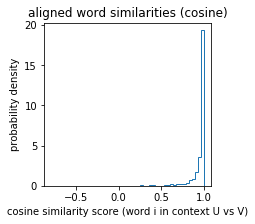

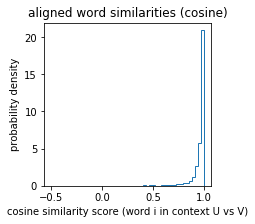

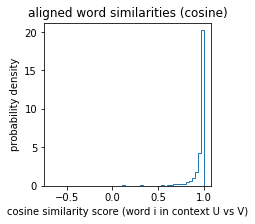

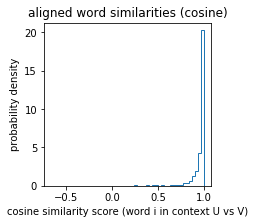

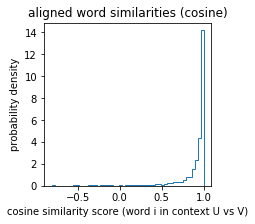

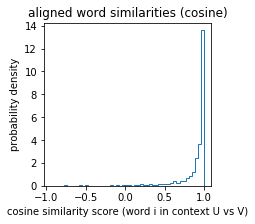

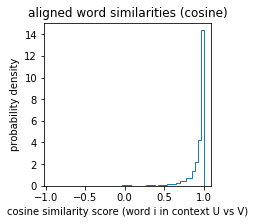

In [12]:
CCA_comparisons = []
for i_community in range(N_communities):
    CCA_comparisons.append([])
    
    # LOAD MODELS
    w2v_models = []  # same community across different samples
    for i_sample in range(N_samples):
        
        print(w2v_names[i_sample][i_community])
        
        path2model = path2dir + w2v_names[i_sample][i_community]
        print(path2model)
        this_model = load_model(path2model)
        w2v_models.append(this_model)
        
        print()
        
    #D = w2v_models[0].trainables.layer1_size  # assume this is matched
    
    # PREPARE COMPARISONS
    i_comparison = 0
    for i_model, modelA in enumerate(w2v_models):
        for j_model, modelB in enumerate(w2v_models):
            
            if i_model < j_model:  # lower triangle only
                
                # book keeping
                CCA_comparisons[i_community].append({})                       # todo check this - added i_community bc
                CCA_comparisons[i_community][i_comparison]['modelA'] = w2v_names[i_model][i_community]
                CCA_comparisons[i_community][i_comparison]['modelB'] = w2v_names[j_model][i_community]
                
                # get shared vocabulary
                shared_vocab = get_shared_vocabulary(modelA, modelB)
                CCA_comparisons[i_community][i_comparison]['shared_vocab'] = shared_vocab
                
                # build sample matrices
                samplesA = build_sample_matrix(modelA, shared_vocab, doPlot=False)
                samplesB = build_sample_matrix(modelB, shared_vocab, doPlot=False)

                # align 2 spaces with cca
                (U, V, cc_corr) = run_cca(samplesA,
                                          samplesB,
                                          N_components=3,
                                          doPlot=False)
                
                # save CCA outputs
                CCA_comparisons[i_community][i_comparison]['U'] = U.tolist()
                CCA_comparisons[i_community][i_comparison]['V'] = V.tolist()
                CCA_comparisons[i_community][i_comparison]['cc_corr'] = cc_corr.tolist()
                
                # get & save word similarity distribution
                word_similarities = plot_word_similarity(U, V, shared_vocab, doSave=False)
                CCA_comparisons[i_community][i_comparison]['word_similarities'] = word_similarities
                
                i_comparison += 1

In [13]:
### export results

In [14]:
save_path = path2dir + 'CCA_same_community_comparison.json'
with open(save_path, 'w') as f:
    json.dump(CCA_comparisons, f)

In [15]:
### perform the alignment (same sample, different communities)

(3, 9)
abstracts_0_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster0_2018_200k_win2.model
2236 words 

(3, 9)
abstracts_0_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster1_2018_200k_win2.model
2201 words 

(3, 9)
abstracts_0_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster2_2018_200k_win2.model
2545 words 

(3, 9)
abstracts_0_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster3_2018_200k_win2.model
2370 words 

(3, 9)
abstracts_0_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster4_2018_200k_win2.model
2565 words 

(3, 9)
abstracts_0_cluster5_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster5_2018_200k_win2.model
2406 words 

(3, 9)
abstracts_0_cluster6_2018_200k_win2.model
data_processing_feb2020/abstracts

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1173


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1139


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 944


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1055


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1305


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1296


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1010


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1137


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1444


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 922


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 984
size of shared vocabulary: 1276


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1247
size of shared vocabulary: 1209


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(3, 9)
abstracts_1_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster0_2018_200k_win2.model
2209 words 

(3, 9)
abstracts_1_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster1_2018_200k_win2.model
2188 words 

(3, 9)
abstracts_1_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster2_2018_200k_win2.model
2527 words 

(3, 9)
abstracts_1_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster3_2018_200k_win2.model
2415 words 

(3, 9)
abstracts_1_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster4_2018_200k_win2.model
2575 words 

(3, 9)
abstracts_1_cluster5_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_1_cluster5_2018_200k_win2.model
2480 words 

(3, 9)
abstracts_1_cluster6_2018_200k_win2.model
data_processing_feb2020/abstracts

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1149


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1033
size of shared vocabulary: 1127


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 973
size of shared vocabulary: 1109


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1044
size of shared vocabulary: 1346


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1270


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1164


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1065


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 888


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 875


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 781
size of shared vocabulary: 914


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1335


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1302


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1208


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1186


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 940


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1121


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1436


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1211
size of shared vocabulary: 1150


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 955
size of shared vocabulary: 1065


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1378


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1356


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1038


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1172


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1551


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 998


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1030


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1268


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1248


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1218


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(3, 9)
abstracts_2_cluster0_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster0_2018_200k_win2.model
2229 words 

(3, 9)
abstracts_2_cluster1_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster1_2018_200k_win2.model
2141 words 

(3, 9)
abstracts_2_cluster2_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster2_2018_200k_win2.model
2522 words 

(3, 9)
abstracts_2_cluster3_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster3_2018_200k_win2.model
2411 words 

(3, 9)
abstracts_2_cluster4_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster4_2018_200k_win2.model
2504 words 

(3, 9)
abstracts_2_cluster5_2018_200k_win2.model
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_2_cluster5_2018_200k_win2.model
2375 words 

(3, 9)
abstracts_2_cluster6_2018_200k_win2.model
data_processing_feb2020/abstracts

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1140


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1034


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1132


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 955


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1136


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1087


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1348


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1221


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1148


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1025
size of shared vocabulary: 858


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 890


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 779
size of shared vocabulary: 880


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1331


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1284


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1167


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1212


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 950


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1090


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1418


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1182


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1186


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 961


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1054


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1304


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1346


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1022


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1126


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1508


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 938


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 946


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1298


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1229


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


size of shared vocabulary: 1225


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


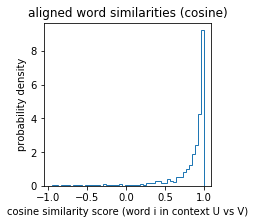

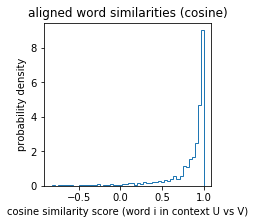

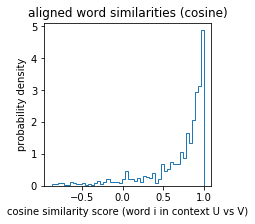

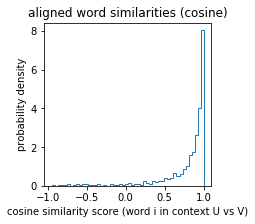

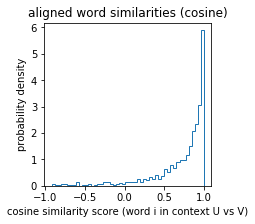

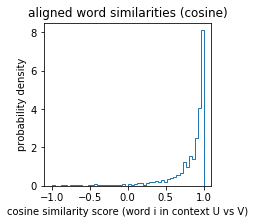

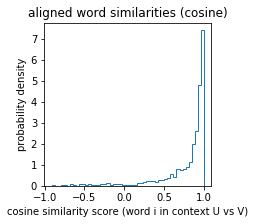

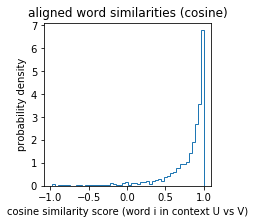

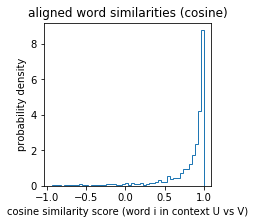

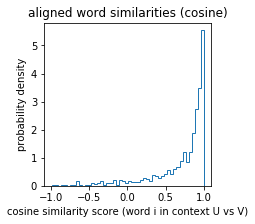

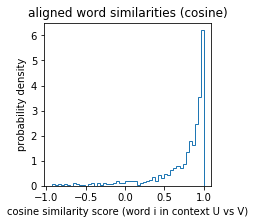

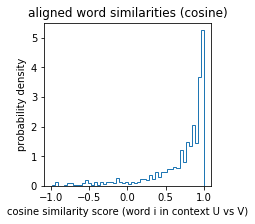

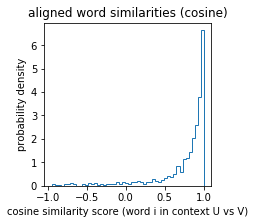

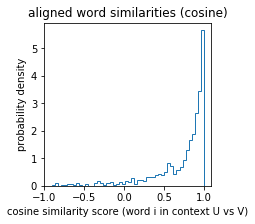

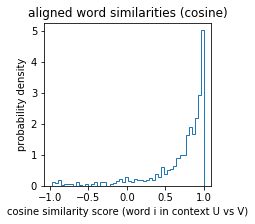

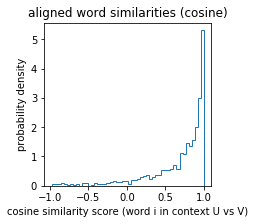

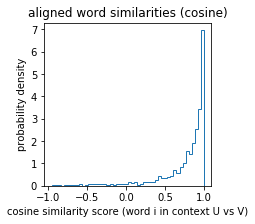

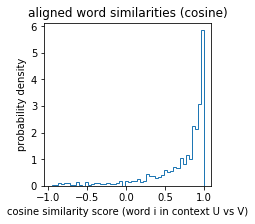

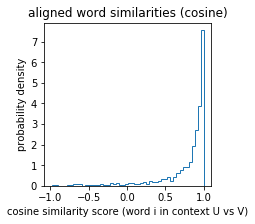

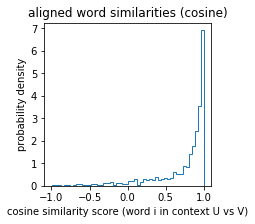

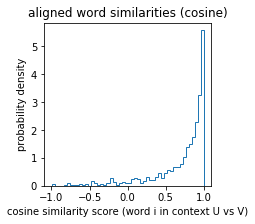

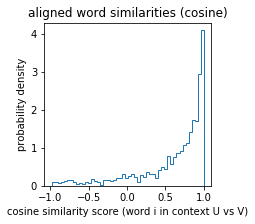

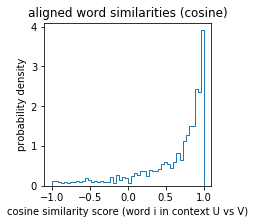

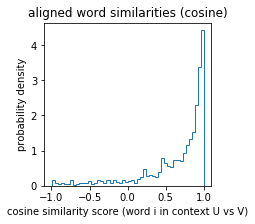

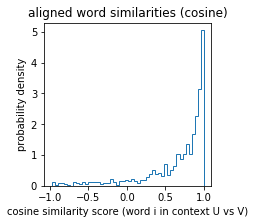

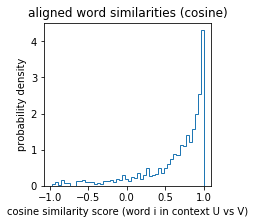

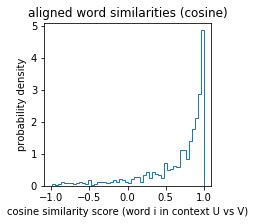

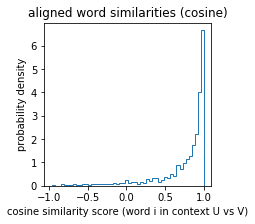

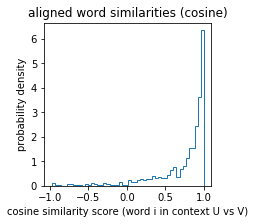

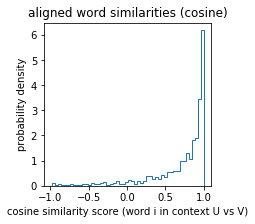

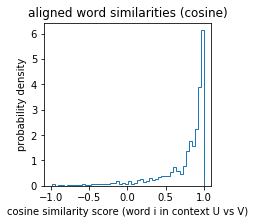

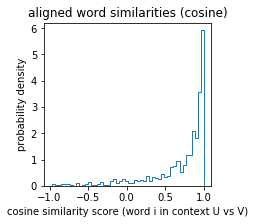

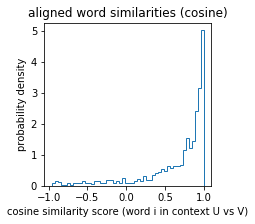

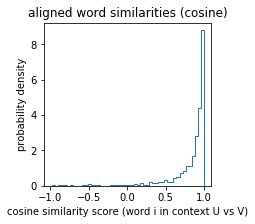

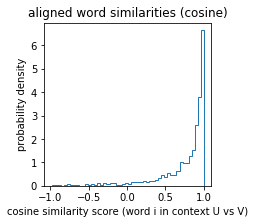

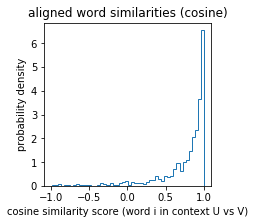

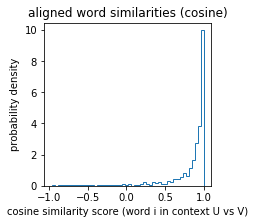

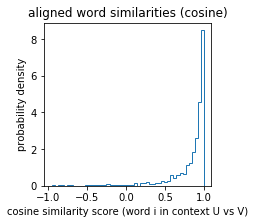

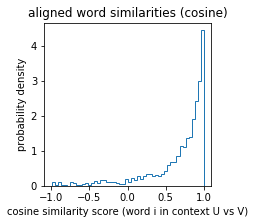

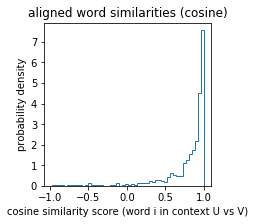

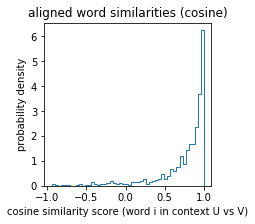

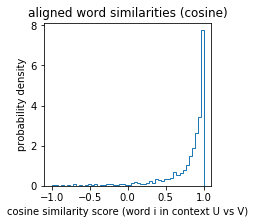

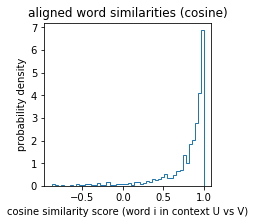

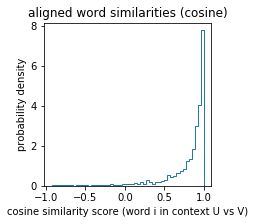

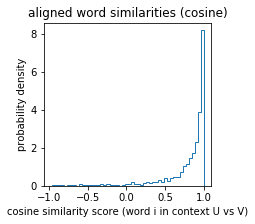

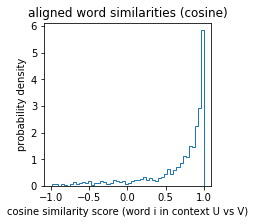

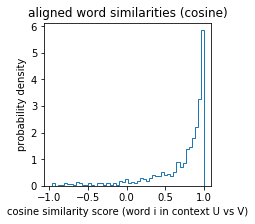

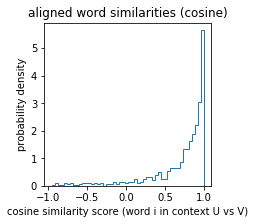

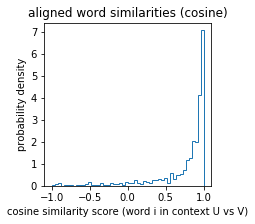

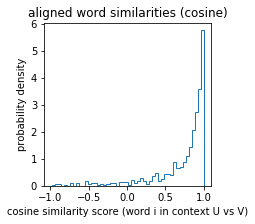

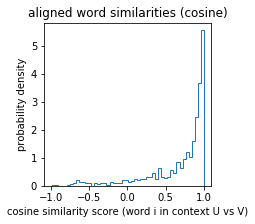

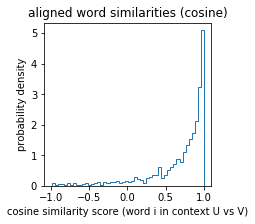

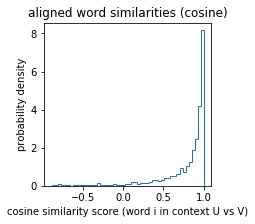

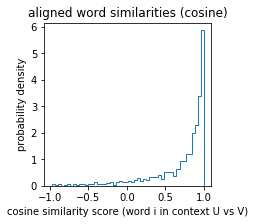

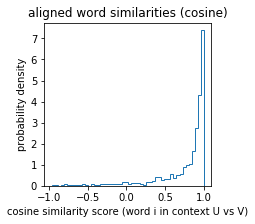

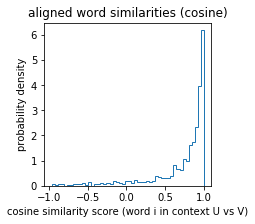

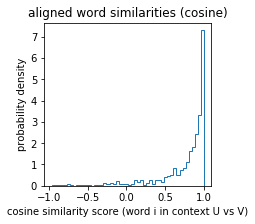

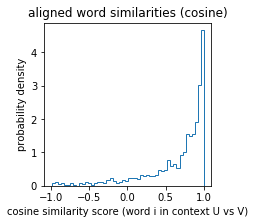

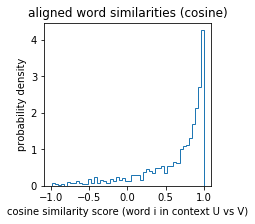

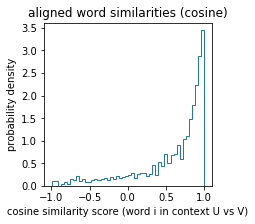

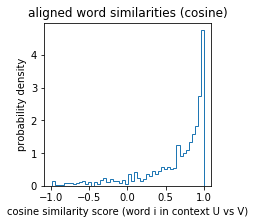

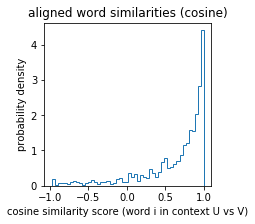

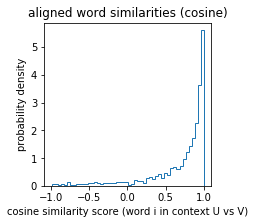

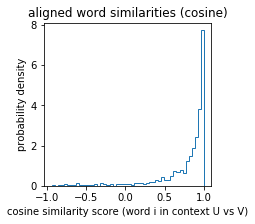

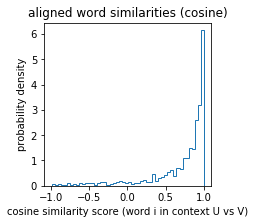

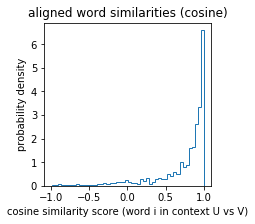

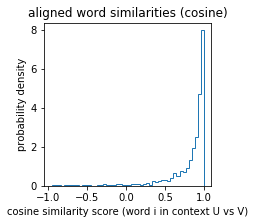

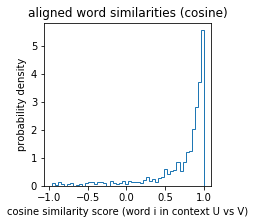

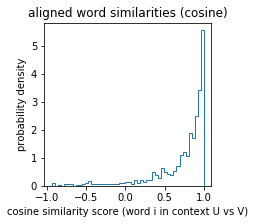

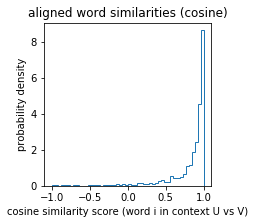

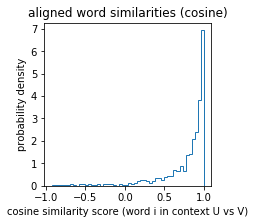

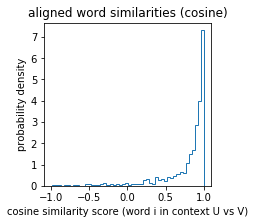

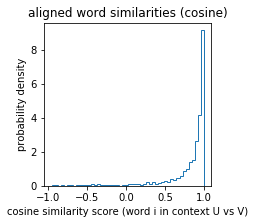

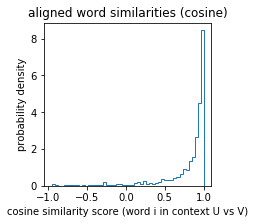

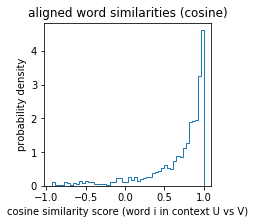

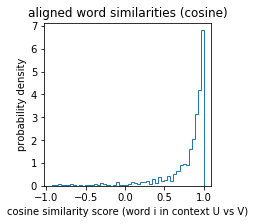

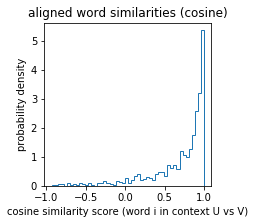

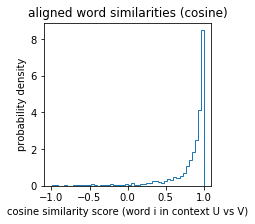

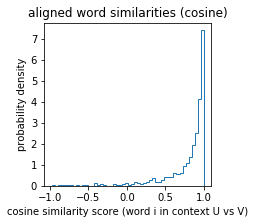

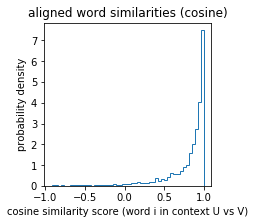

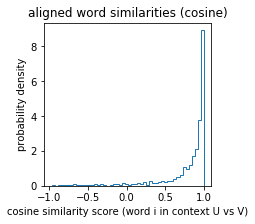

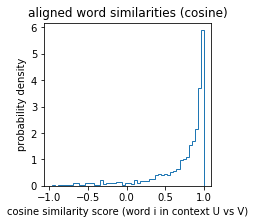

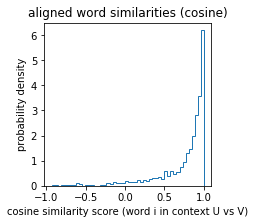

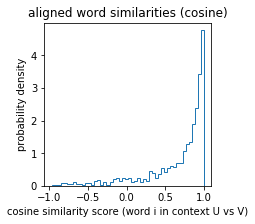

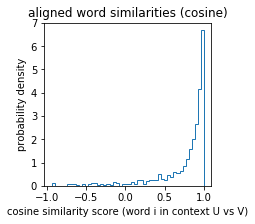

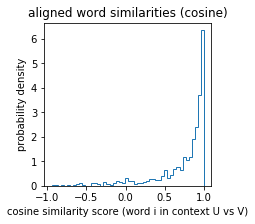

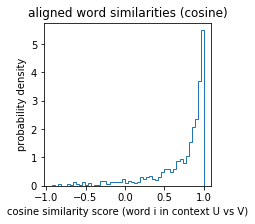

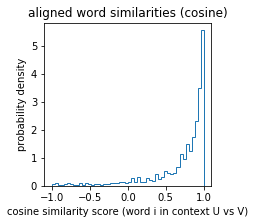

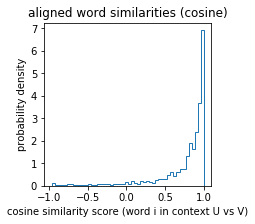

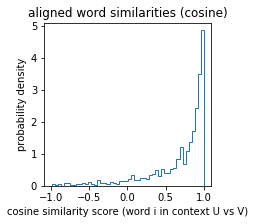

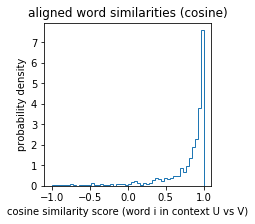

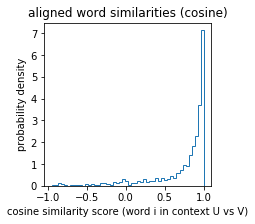

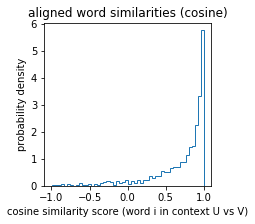

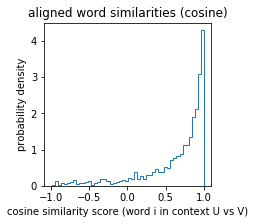

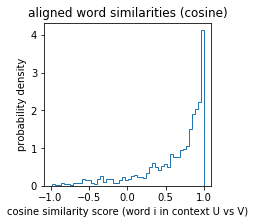

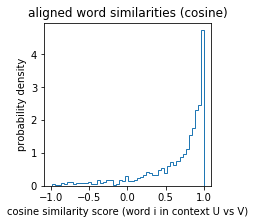

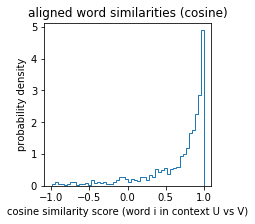

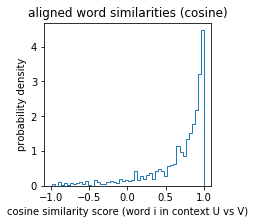

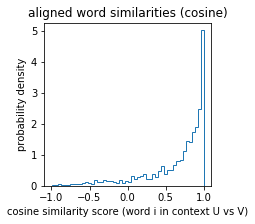

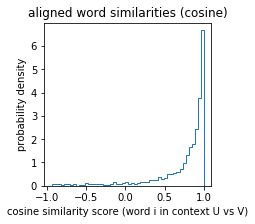

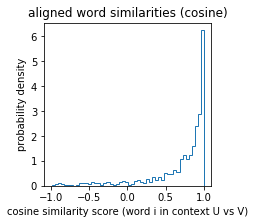

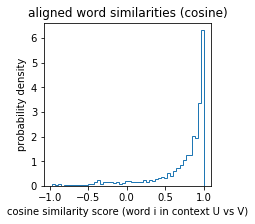

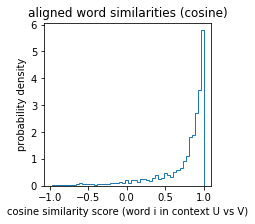

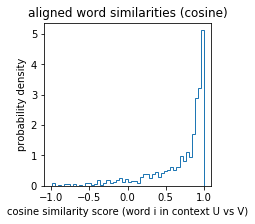

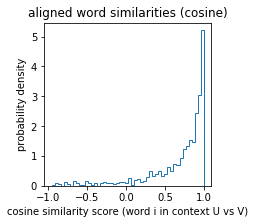

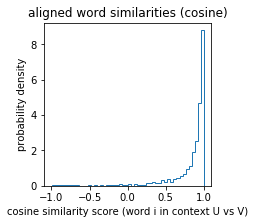

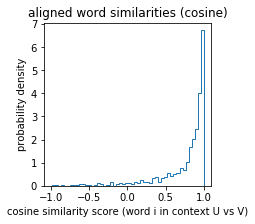

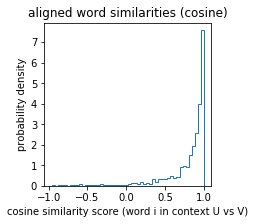

In [16]:
CCA_comparisons = []
for i_sample in range(N_samples):
    CCA_comparisons.append([])
    
    # LOAD MODELS
    w2v_models = []  # same community across different samples
    for i_community in range(N_communities):
        
        print(np.shape(w2v_names))
        print(w2v_names[i_sample][i_community])
        
        path2model = path2dir + w2v_names[i_sample][i_community]
        print(path2model)
        this_model = load_model(path2model)
        w2v_models.append(this_model)
        
        print()
        
    #D = w2v_models[0].trainables.layer1_size  # assume this is matched
    
    # PREPARE COMPARISONS
    i_comparison = 0
    for i_model, modelA in enumerate(w2v_models):
        for j_model, modelB in enumerate(w2v_models):
            
            if i_model < j_model:  # lower triangle only
                
                # book keeping
                CCA_comparisons[i_sample].append({})      # todo check this name indexing bc
                CCA_comparisons[i_sample][i_comparison]['modelA'] = w2v_names[i_sample][i_model]
                CCA_comparisons[i_sample][i_comparison]['modelB'] = w2v_names[i_sample][j_model]
                
                # get shared vocabulary
                shared_vocab = get_shared_vocabulary(modelA, modelB)
                CCA_comparisons[i_sample][i_comparison]['shared_vocab'] = shared_vocab
                
                # build sample matrices
                samplesA = build_sample_matrix(modelA, shared_vocab, doPlot=False)
                samplesB = build_sample_matrix(modelB, shared_vocab, doPlot=False)

                # align 2 spaces with cca
                (U, V, cc_corr) = run_cca(samplesA,
                                          samplesB,
                                          N_components=3,
                                          doPlot=False)
                
                # save CCA outputs
                CCA_comparisons[i_sample][i_comparison]['U'] = U.tolist()
                CCA_comparisons[i_sample][i_comparison]['V'] = V.tolist()
                CCA_comparisons[i_sample][i_comparison]['cc_corr'] = cc_corr.tolist()
                
                # get & save word similarity distribution
                word_similarities = plot_word_similarity(U, V, shared_vocab, doSave=False)
                CCA_comparisons[i_sample][i_comparison]['word_similarities'] = word_similarities
                
                i_comparison += 1

In [17]:
save_path = path2dir + 'CCA_cross_community_comparison.json'
with open(save_path, 'w') as f:
    json.dump(CCA_comparisons, f)

In [18]:
### aggregate for plot

load_path = path2dir + 'CCA_cross_community_comparison.json'
with open(load_path, 'r') as f:
    CCA_comparisons = json.load(f)

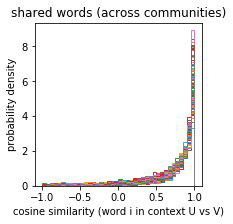

In [19]:
# aggregate cross-cluster word-scores
wordsimilarity_between = []


plt.figure(figsize=(3,3))

for i_sample in range(N_samples):
    
    comparisons = CCA_comparisons[i_sample]
    BINS = np.linspace(-1,1,41)
    for i_comparison, comparison in enumerate(comparisons):
        
        scores = CCA_comparisons[i_sample][i_comparison]['word_similarities']
        plt.hist(scores,
                histtype='step',
                bins=BINS,
                density=True)
        
        wordsimilarity_between = wordsimilarity_between + scores
        
plt.title('shared words (across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')

figname = path2dir + 'cca_wordsim_between__juxtapose'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


In [20]:
### reload the same-community comparison

In [21]:
load_path = path2dir + 'CCA_same_community_comparison.json'
with open(load_path, 'r') as f:
    CCA_comparisons = json.load(f)

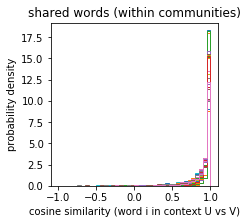

In [22]:
# aggregate cross-cluster word-scores
wordsimilarity_within = []


plt.figure(figsize=(3,3))

for i_sample in range(N_communities):
    
    comparisons = CCA_comparisons[i_sample]
    BINS = np.linspace(-1,1,41)
    for i_comparison, comparison in enumerate(comparisons):
        
        scores = CCA_comparisons[i_sample][i_comparison]['word_similarities']
        plt.hist(scores,
                histtype='step',
                bins=BINS,
                density=True)
        
        wordsimilarity_within = wordsimilarity_within + scores
        
plt.title('shared words (within communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')

        
figname = path2dir + 'cca_wordsim_within__juxtapose'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


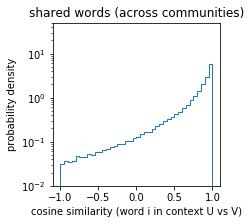

In [23]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_between,
                histtype='step',
                bins=BINS,
                density=True,         
                color='#1f78b4')

plt.title('shared words (across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_between__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')

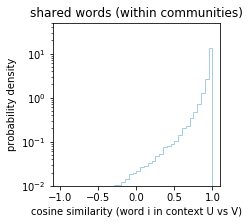

In [24]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_within,
                histtype='step',
                bins=BINS,
                density=True,
                color='#a6cee3')

plt.title('shared words (within communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_within__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')

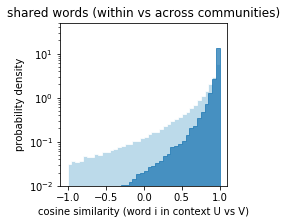

In [25]:
plt.figure(figsize=(3,3))

plt.hist(wordsimilarity_between,
                histtype='stepfilled',
                bins=BINS,
                density=True,    
                edgecolor='#ffffff',
                facecolor='#a6cee3',
                alpha=0.75,
                linewidth=1)

plt.hist(wordsimilarity_within,
                histtype='stepfilled',
                bins=BINS,
                density=True,
                edgecolor='#1f78b4',
                facecolor='#1f78b4',
                alpha=0.75,
                linewidth=1)

plt.title('shared words (within vs across communities)')
plt.xlabel('cosine similarity (word i in context U vs V)')
plt.ylabel('probability density')
plt.yscale('log', nonposy='clip')
plt.ylim([0.01,50])

figname = path2dir + 'cca_wordsim_combined__aggregate'
plt.savefig(figname + '.png')
plt.savefig(figname + '.pdf')


### embedding2network helper function

In [26]:
import networkx as nx

# todo helper function embedding2network
def embedding2network(model, P_thresh=99, doPlot=True):
    '''
    helper function for moving between representations.
    take an embedding space and use cosine similarity
    to re-encode as a network.
    assume relationships are sparse and threshold-mask weak edges.
    '''
    D = model.wv.vectors.shape[1] # dimensionality of a sample word, any word will do
    print("number of dimensions D: {}".format(D))

    embedding_samples = np.zeros( (len(model.wv.vocab), D) )

    # collect samples
    d_names = {}
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] = model.wv[word] 
        d_names[word] = i_word
    # demean
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
    # compute edge weights via cosine similarity (projection of normalized vectors)
    W = np.matmul(embedding_samples, embedding_samples.T)
    W_raw = W.copy()
    # threshold and clean adjmat
    np.fill_diagonal(W, 0)  # no self-loops
    thresh_high = np.percentile(W.flatten(), P_thresh)
    boolean_mask = W < thresh_high
    W[boolean_mask] = 0 # 
    print("dimensions: {}".format(np.shape(W)))

    if doPlot:
        fig, axs = plt.subplots(1, 2,
                                sharex='col', sharey='col',
                               figsize=(4,2))

        axs[0].imshow(W, # [:300,:300],
                         aspect='auto',
                         cmap='magma')

        #axs[0,idx].colorbar()
        BINS = np.linspace(0,1,100)
        axs[1].hist(np.tril(W_raw,k=-1)[np.tril(W_raw,k=-1).nonzero()].flatten(),
                        histtype='step',
                        density=False,
                        color=[0.3,0.3,0.3],
                        linestyle='--',
                        bins=BINS,
                        alpha=0.5)
        axs[1].hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),
                       histtype='step',
                        density=False,
                        color=[0,0.6, 0.8],
                        bins=BINS)
        axs[1].set_xlim([0,1])

    print('--------------')

    G_nx = nx.from_numpy_matrix(W)  # convert to graph for centrality computation
    nx.set_node_attributes(G_nx,
                           dict((i,w) for i,w in enumerate(model.wv.vocab)),
                           'word')
    d_cent = nx.degree_centrality(G_nx)  # , max_iter=200)
    nx.set_node_attributes(G_nx, d_cent, 'centrality')  # formerly eigen centrality

    return G_nx, d_names

9 communities in sample 0
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster0_2018_200k_win2.model
number of dimensions D: 20
dimensions: (2236, 2236)
--------------
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster1_2018_200k_win2.model
number of dimensions D: 20
dimensions: (2201, 2201)
--------------
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster2_2018_200k_win2.model
number of dimensions D: 20
dimensions: (2545, 2545)
--------------
data_processing_feb2020/abstracts_2018_200k_win2/abstracts_0_cluster3_2018_200k_win2.model
number of dimensions D: 20
dim

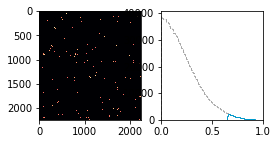

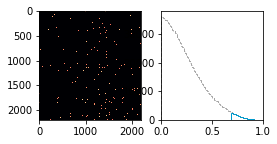

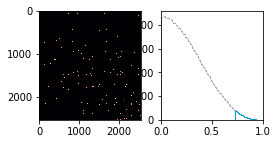

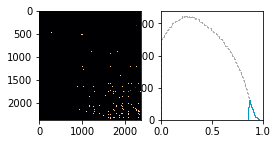

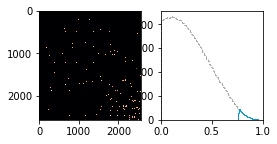

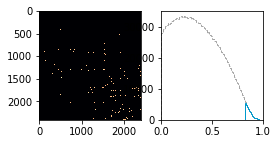

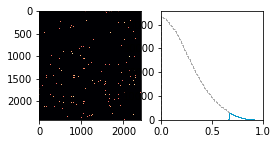

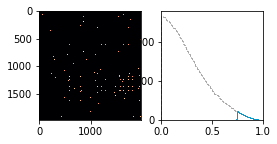

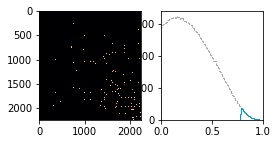

In [33]:
### obtain semantic networks:

# first, get file names for the models

files_list = [f for f in os.listdir(path2dir) if '.model' in f]
w2v_names = []
 
i_sample=0
#for i_sample in range(N_samples):
    
sample_models = [f for f in files_list if '{}_cluster'.format(i_sample) in f]
N_communities = len(sample_models)
print("{} communities in sample {}".format(N_communities, i_sample))
w2v_names.append([])
for i_community in range(N_communities):

    for j_path in sample_models:
        if 'cluster{}'.format(i_community) in j_path:
            this_path = j_path
    w2v_names[i_sample].append(this_path)
    print(w2v_names[i_sample][i_community])

print()

nx_graphs = {}
node_names = {}
for i_model, model_name in enumerate(w2v_names[i_sample]):

    path = path2dir + model_name
    print(path)
    model = Word2Vec.load(path)
    
    P_thresh = 99
    doPlot=True
    G_nx, d_names = embedding2network(model, P_thresh, doPlot)
    nx_graphs[model_name] = G_nx
    node_names[model_name] = d_names

In [28]:
def plot_ego_graph(G, node, title='default_title'):
    G_ego = nx.ego_graph(G, node)
    d_layout = nx.spring_layout(G_ego)
    
    #edges, weights = zip(*nx.get_edge_attributes(G_ego, 'weight').items())
    labels = nx.get_node_attributes(G_ego, 'word')
    
    plt.figure()
    nx.draw_networkx(G_ego,
           pos=d_layout, #
           with_labels=True,
           labels=labels,
           fontsize=2,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=5000, #
           width=0.25,
           edge_cmap=plt.cm.Blues) 
    
    #plt.autoscale()
    plt.savefig('{}{}.png'.format(path2dir, title))
    plt.savefig('{}{}.pdf'.format(path2dir, title))
    
    plt.show()
    #
           #edgelist=edges,
           #edge_color=weights,

### get large-distance words from each pair

In [29]:
### load cross-community comparisons

load_path = path2dir + 'CCA_cross_community_comparison.json'
with open(load_path, 'r') as f:
    CCA_comparisons = json.load(f)

[('poor', -0.955530774760188), ('another', -0.8956169670455039), ('target', -0.8861847052475891)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster1_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: poor -0.955530774760188


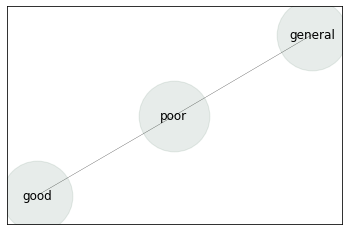

abstracts_0_cluster1_2018_200k_win2.model: poor -0.955530774760188


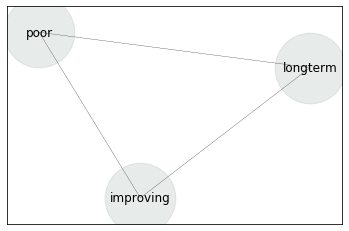

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: another -0.8956169670455039


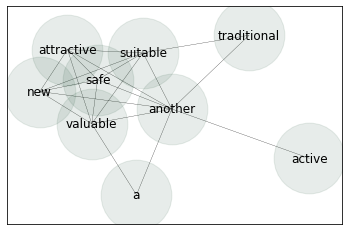

abstracts_0_cluster1_2018_200k_win2.model: another -0.8956169670455039


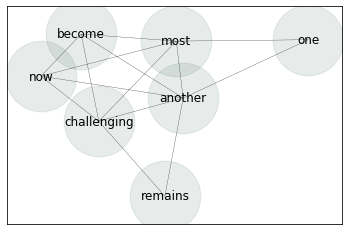

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: target -0.8861847052475891


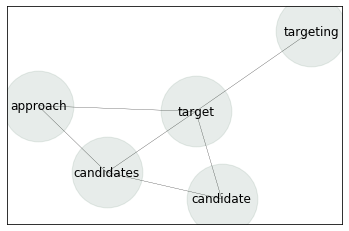

abstracts_0_cluster1_2018_200k_win2.model: target -0.8861847052475891


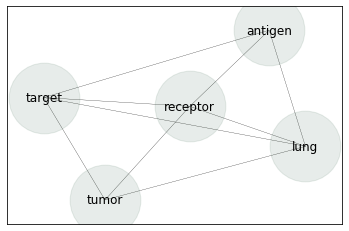

-----------------------------------
[('advanced', -0.8255899263528388), ('cancer', -0.8149488888379595), ('an', -0.7900754805107382)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster2_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: advanced -0.8255899263528388


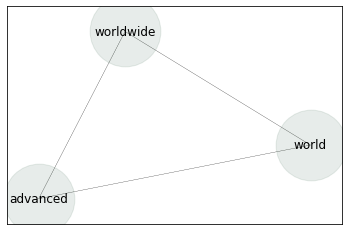

abstracts_0_cluster2_2018_200k_win2.model: advanced -0.8255899263528388


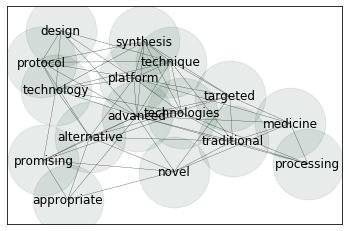

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: cancer -0.8149488888379595


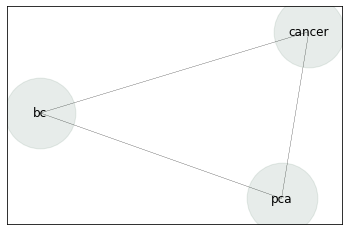

abstracts_0_cluster2_2018_200k_win2.model: cancer -0.8149488888379595


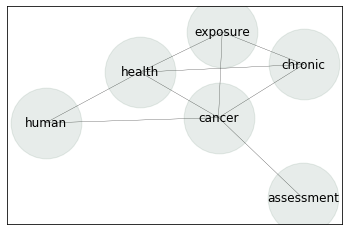

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: an -0.7900754805107382


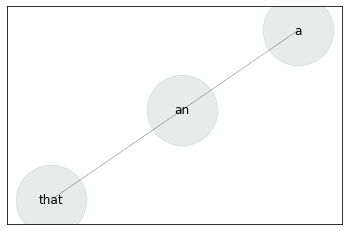

abstracts_0_cluster2_2018_200k_win2.model: an -0.7900754805107382


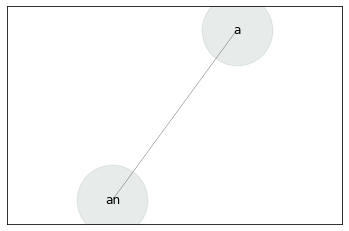

-----------------------------------
[('general', -0.8718710786033308), ('active', -0.865607261914124), ('capacity', -0.801743098905666)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster3_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: general -0.8718710786033308


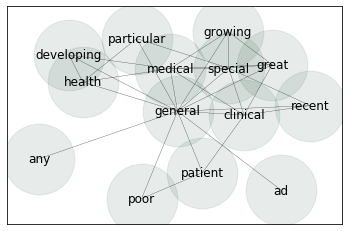

abstracts_0_cluster3_2018_200k_win2.model: general -0.8718710786033308


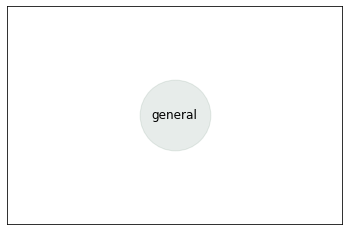

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: active -0.865607261914124


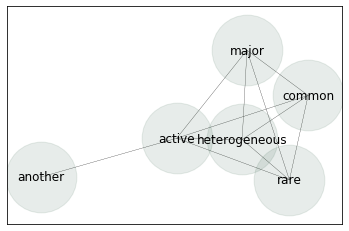

abstracts_0_cluster3_2018_200k_win2.model: active -0.865607261914124


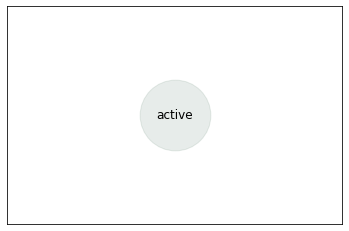

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: capacity -0.801743098905666


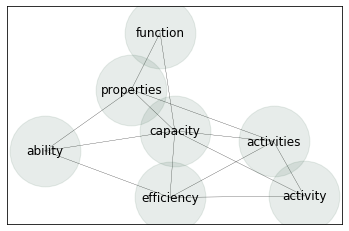

abstracts_0_cluster3_2018_200k_win2.model: capacity -0.801743098905666


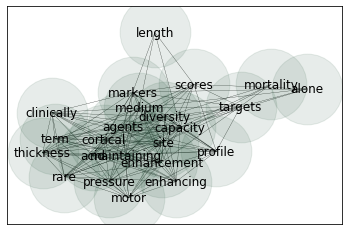

-----------------------------------
[('individual', -0.9484493318323985), ('treatments', -0.855318111726552), ('failure', -0.853297105017979)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: individual -0.9484493318323985


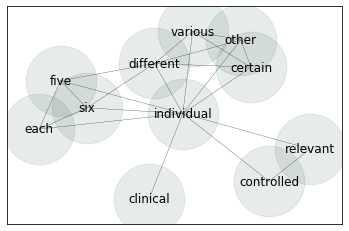

abstracts_0_cluster4_2018_200k_win2.model: individual -0.9484493318323985


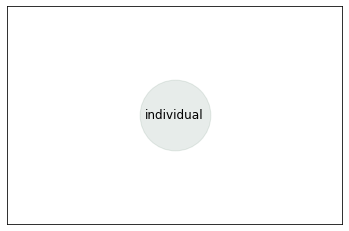

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: treatments -0.855318111726552


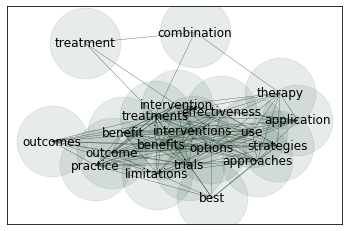

abstracts_0_cluster4_2018_200k_win2.model: treatments -0.855318111726552


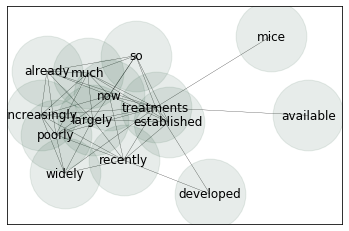

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: failure -0.853297105017979


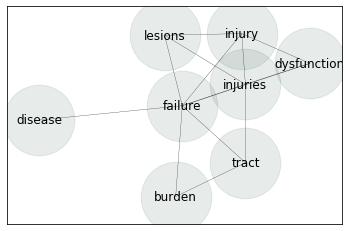

abstracts_0_cluster4_2018_200k_win2.model: failure -0.853297105017979


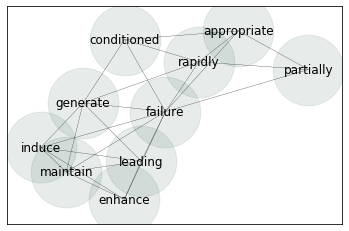

-----------------------------------
[('problem', -0.9177006822692901), ('finding', -0.9139496064058896), ('options', -0.9047120701952371)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: problem -0.9177006822692901


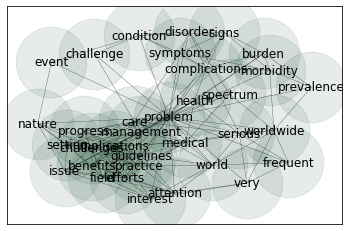

abstracts_0_cluster5_2018_200k_win2.model: problem -0.9177006822692901


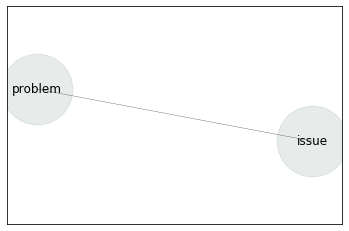

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: finding -0.9139496064058896


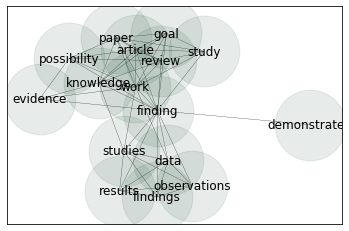

abstracts_0_cluster5_2018_200k_win2.model: finding -0.9139496064058896


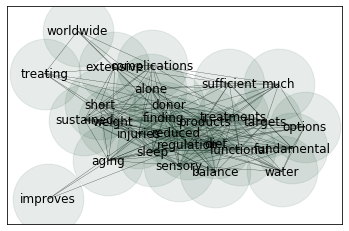

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: options -0.9047120701952371


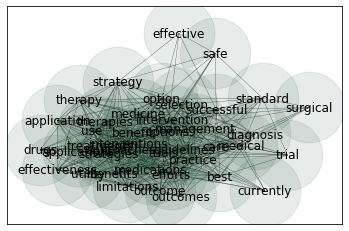

abstracts_0_cluster5_2018_200k_win2.model: options -0.9047120701952371


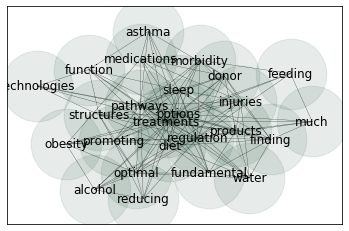

-----------------------------------
[('their', -0.998936138509174), ('natural', -0.9635715065651438), ('six', -0.8493849175311965)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: their -0.998936138509174


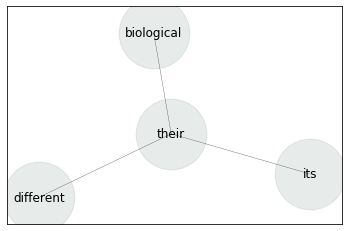

abstracts_0_cluster6_2018_200k_win2.model: their -0.998936138509174


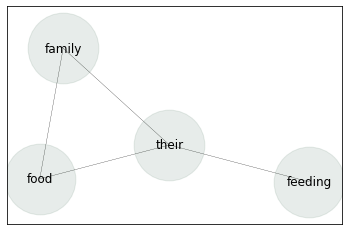

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: natural -0.9635715065651438


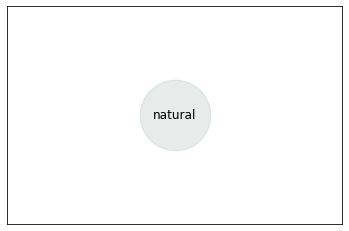

abstracts_0_cluster6_2018_200k_win2.model: natural -0.9635715065651438


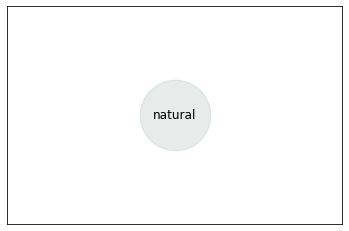

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: six -0.8493849175311965


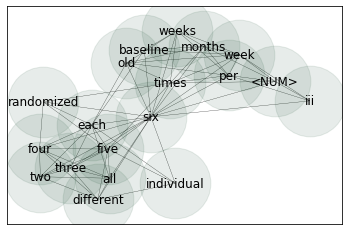

abstracts_0_cluster6_2018_200k_win2.model: six -0.8493849175311965


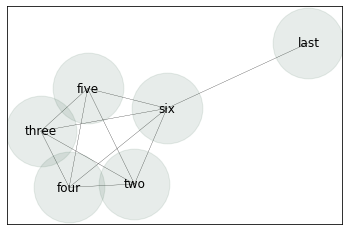

-----------------------------------
[('distinct', -0.9106476680792928), ('general', -0.7599575080407719), ('term', -0.7216311400507656)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: distinct -0.9106476680792928


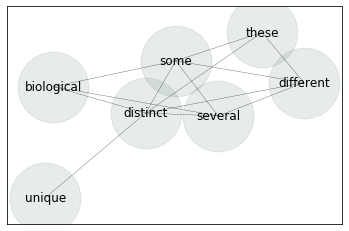

abstracts_0_cluster7_2018_200k_win2.model: distinct -0.9106476680792928


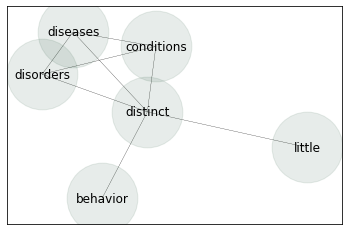

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: general -0.7599575080407719


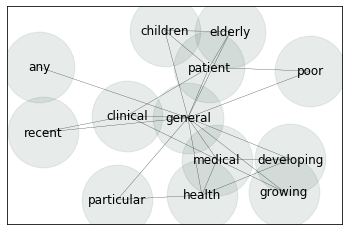

abstracts_0_cluster7_2018_200k_win2.model: general -0.7599575080407719


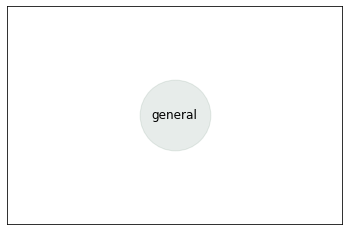

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: term -0.7216311400507656


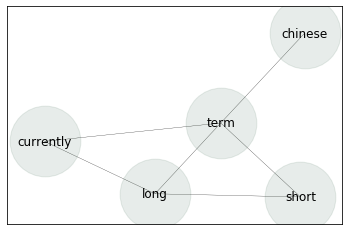

abstracts_0_cluster7_2018_200k_win2.model: term -0.7216311400507656


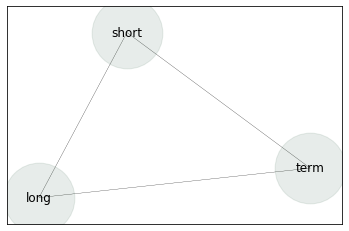

-----------------------------------
[('peptide', -0.9801642006967493), ('following', -0.9759496493963944), ('mirnas', -0.965124100063538)]
model names: 
abstracts_0_cluster0_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster0_2018_200k_win2.model: peptide -0.9801642006967493


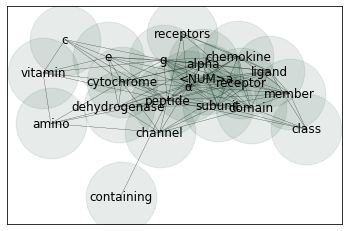

abstracts_0_cluster8_2018_200k_win2.model: peptide -0.9801642006967493


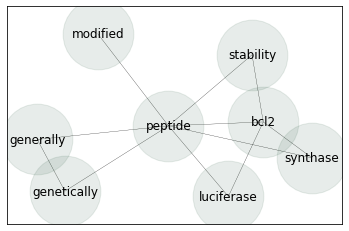

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: following -0.9759496493963944


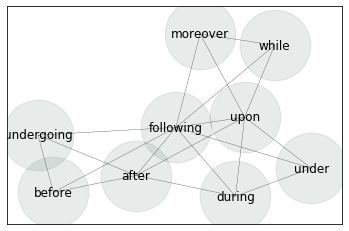

abstracts_0_cluster8_2018_200k_win2.model: following -0.9759496493963944


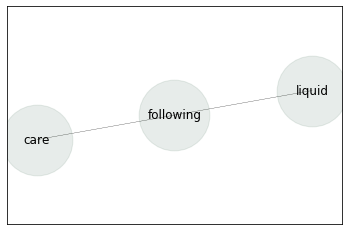

-----------------------------------
abstracts_0_cluster0_2018_200k_win2.model: mirnas -0.965124100063538


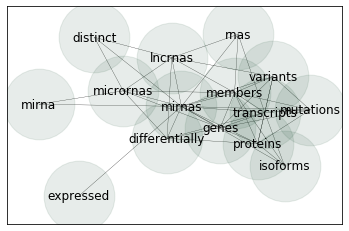

abstracts_0_cluster8_2018_200k_win2.model: mirnas -0.965124100063538


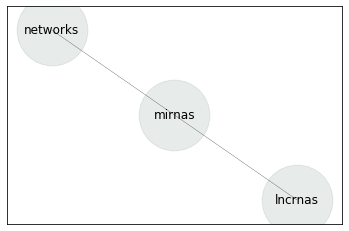

-----------------------------------
[('element', -0.9414621636991034), ('ms', -0.9322776979005103), ('microscopy', -0.9029106873304287)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster2_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: element -0.9414621636991034


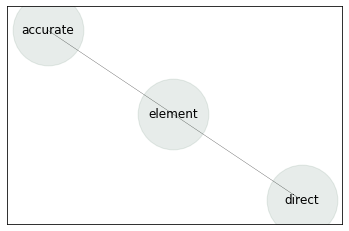

abstracts_0_cluster2_2018_200k_win2.model: element -0.9414621636991034


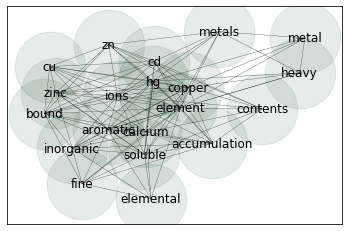

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: ms -0.9322776979005103


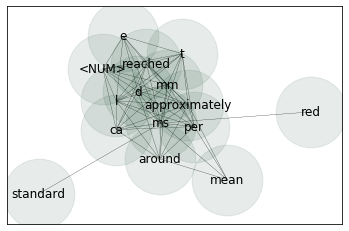

abstracts_0_cluster2_2018_200k_win2.model: ms -0.9322776979005103


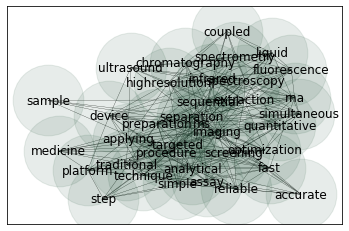

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: microscopy -0.9029106873304287


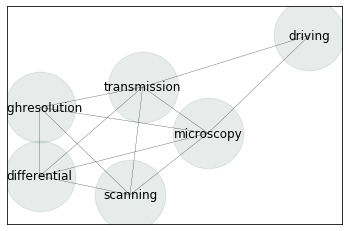

abstracts_0_cluster2_2018_200k_win2.model: microscopy -0.9029106873304287


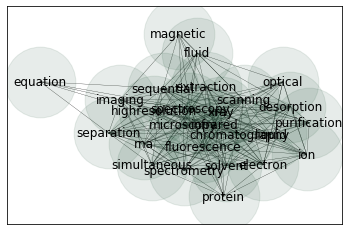

-----------------------------------
[('desired', -0.9903422021634114), ('material', -0.9867893605736877), ('condition', -0.943063759062156)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster3_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: desired -0.9903422021634114


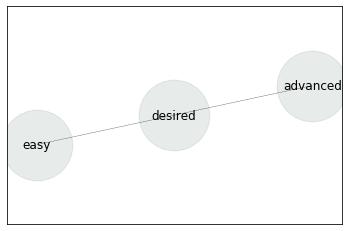

abstracts_0_cluster3_2018_200k_win2.model: desired -0.9903422021634114


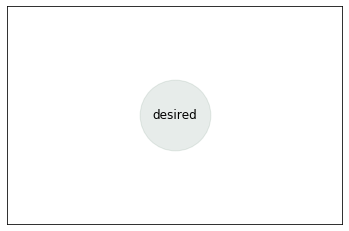

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: material -0.9867893605736877


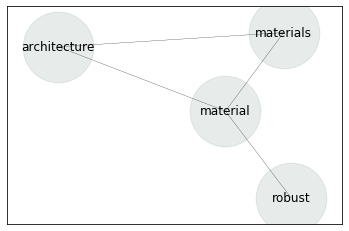

abstracts_0_cluster3_2018_200k_win2.model: material -0.9867893605736877


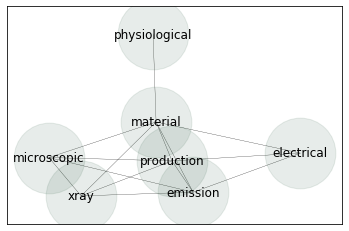

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: condition -0.943063759062156


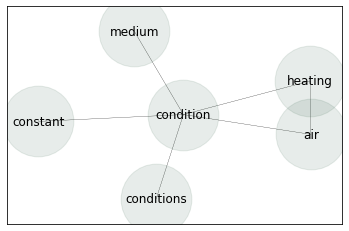

abstracts_0_cluster3_2018_200k_win2.model: condition -0.943063759062156


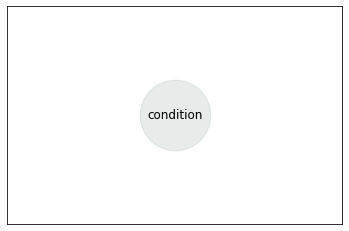

-----------------------------------
[('i', -0.9296020886838825), ('drug', -0.9295321132478569), ('successful', -0.9220763990605105)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: i -0.9296020886838825


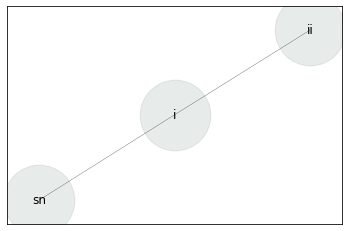

abstracts_0_cluster4_2018_200k_win2.model: i -0.9296020886838825


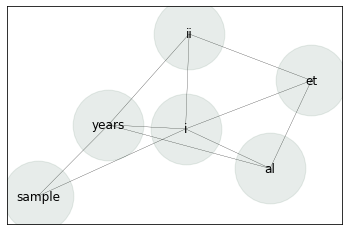

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: drug -0.9295321132478569


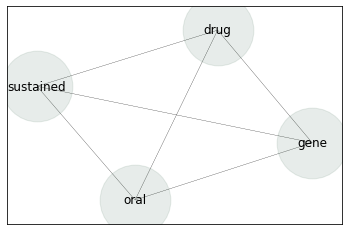

abstracts_0_cluster4_2018_200k_win2.model: drug -0.9295321132478569


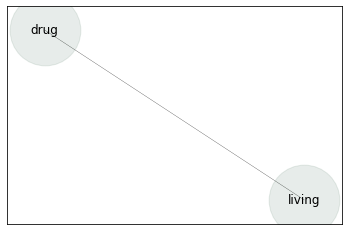

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: successful -0.9220763990605105


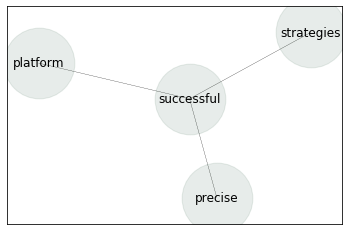

abstracts_0_cluster4_2018_200k_win2.model: successful -0.9220763990605105


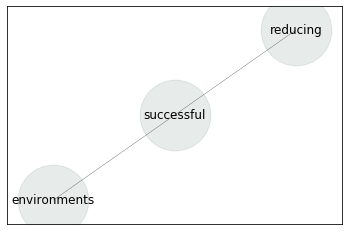

-----------------------------------
[('specific', -0.9925679718610017), ('recent', -0.9462512758678767), ('another', -0.9438496021439322)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: specific -0.9925679718610017


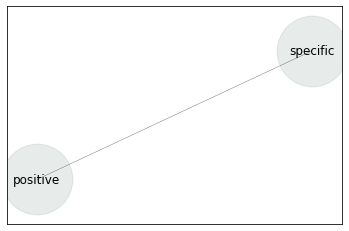

abstracts_0_cluster5_2018_200k_win2.model: specific -0.9925679718610017


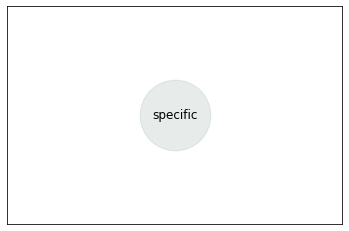

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: recent -0.9462512758678767


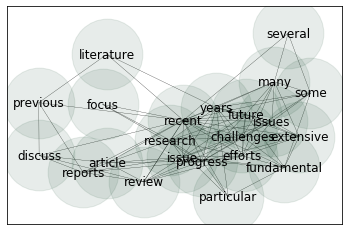

abstracts_0_cluster5_2018_200k_win2.model: recent -0.9462512758678767


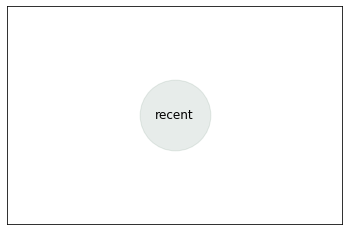

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: another -0.9438496021439322


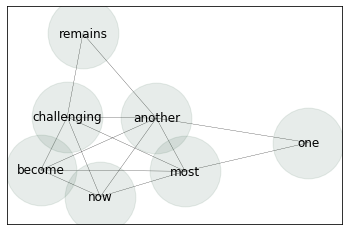

abstracts_0_cluster5_2018_200k_win2.model: another -0.9438496021439322


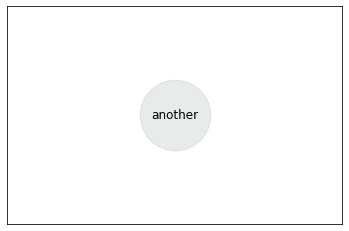

-----------------------------------
[('text', -0.9473074247992987), ('targeted', -0.9428520471315482), ('controlled', -0.8825715046032947)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: text -0.9473074247992987


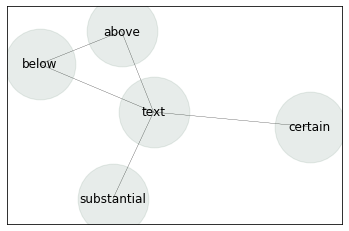

abstracts_0_cluster6_2018_200k_win2.model: text -0.9473074247992987


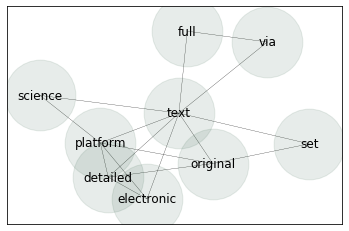

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: targeted -0.9428520471315482


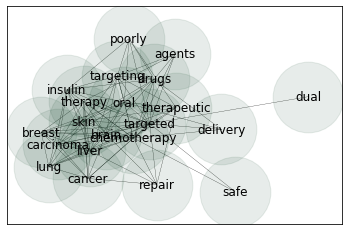

abstracts_0_cluster6_2018_200k_win2.model: targeted -0.9428520471315482


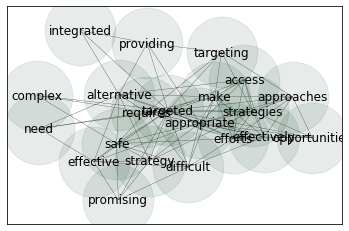

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: controlled -0.8825715046032947


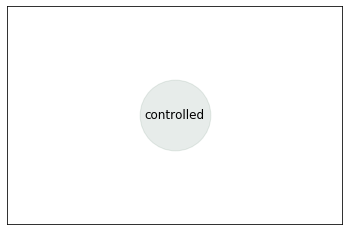

abstracts_0_cluster6_2018_200k_win2.model: controlled -0.8825715046032947


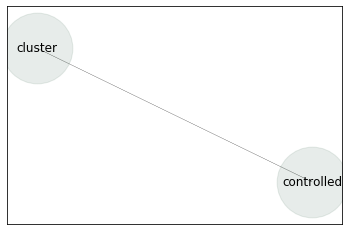

-----------------------------------
[('resistance', -0.9096645889578621), ('current', -0.8635775311292688), ('simple', -0.8587643639264868)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: resistance -0.9096645889578621


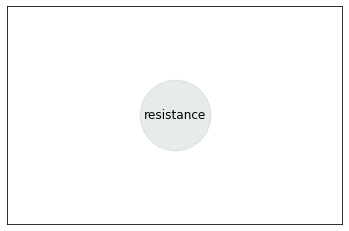

abstracts_0_cluster7_2018_200k_win2.model: resistance -0.9096645889578621


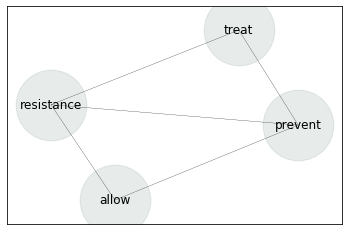

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: current -0.8635775311292688


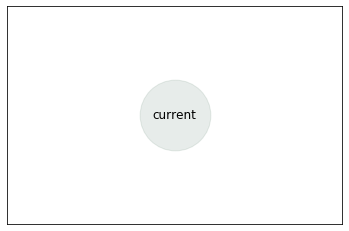

abstracts_0_cluster7_2018_200k_win2.model: current -0.8635775311292688


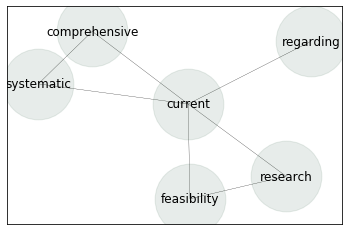

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: simple -0.8587643639264868


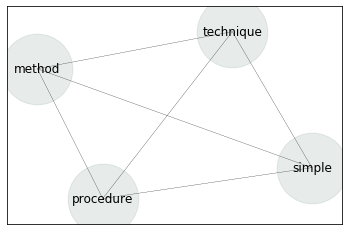

abstracts_0_cluster7_2018_200k_win2.model: simple -0.8587643639264868


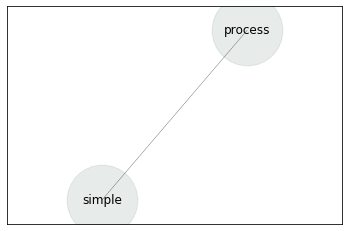

-----------------------------------
[('next', -0.9741257884373788), ('secondary', -0.9522301682596801), ('control', -0.9482345182045575)]
model names: 
abstracts_0_cluster1_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster1_2018_200k_win2.model: next -0.9741257884373788


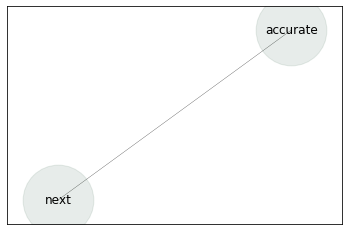

abstracts_0_cluster8_2018_200k_win2.model: next -0.9741257884373788


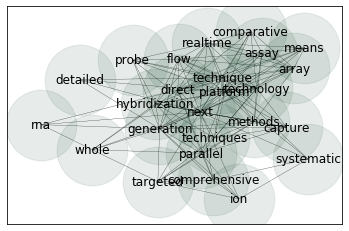

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: secondary -0.9522301682596801


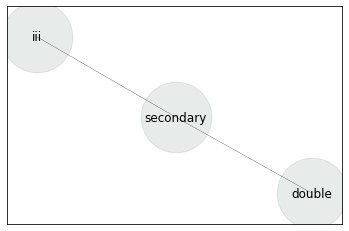

abstracts_0_cluster8_2018_200k_win2.model: secondary -0.9522301682596801


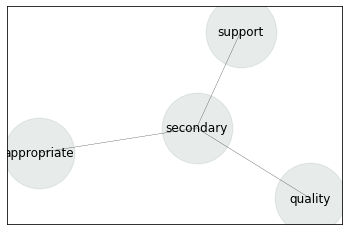

-----------------------------------
abstracts_0_cluster1_2018_200k_win2.model: control -0.9482345182045575


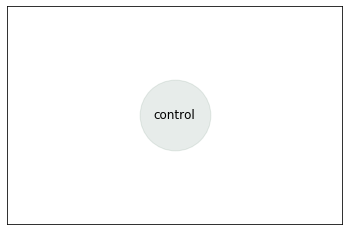

abstracts_0_cluster8_2018_200k_win2.model: control -0.9482345182045575


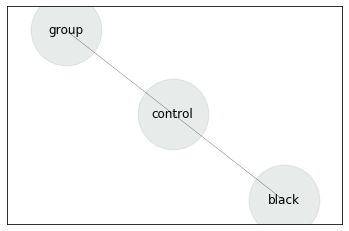

-----------------------------------
[('individuals', -0.9740249528201756), ('variable', -0.95506498691039), ('theoretical', -0.9510259086138979)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster3_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: individuals -0.9740249528201756


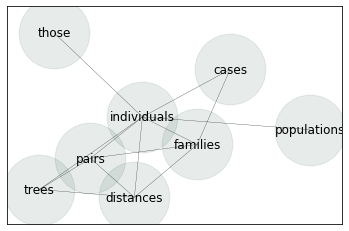

abstracts_0_cluster3_2018_200k_win2.model: individuals -0.9740249528201756


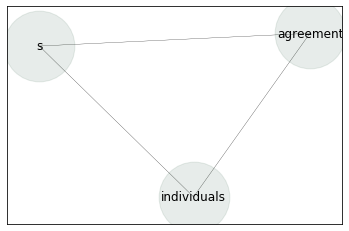

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: variable -0.95506498691039


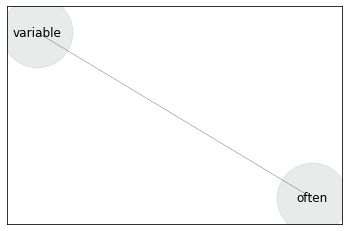

abstracts_0_cluster3_2018_200k_win2.model: variable -0.95506498691039


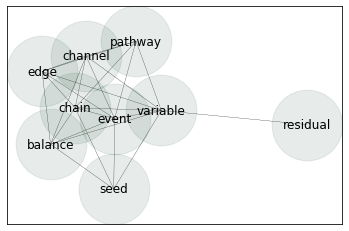

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: theoretical -0.9510259086138979


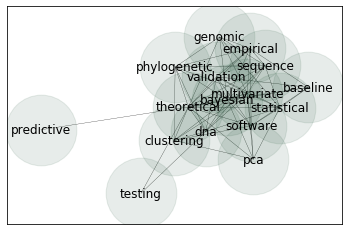

abstracts_0_cluster3_2018_200k_win2.model: theoretical -0.9510259086138979


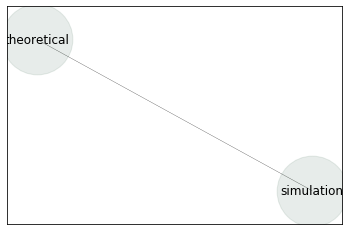

-----------------------------------
[('growing', -0.9498305284823121), ('cases', -0.9344255366580221), ('specific', -0.8816255451614738)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: growing -0.9498305284823121


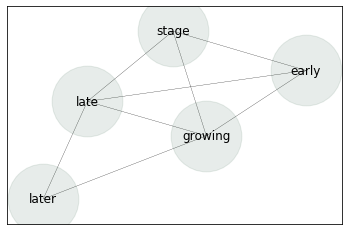

abstracts_0_cluster4_2018_200k_win2.model: growing -0.9498305284823121


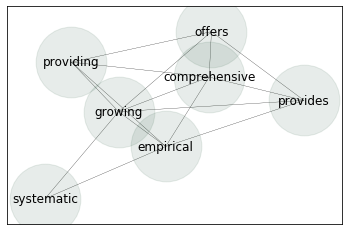

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: cases -0.9344255366580221


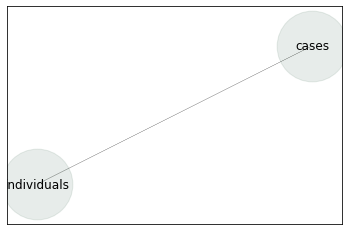

abstracts_0_cluster4_2018_200k_win2.model: cases -0.9344255366580221


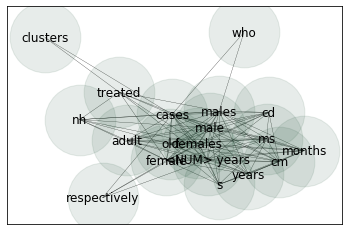

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: specific -0.8816255451614738


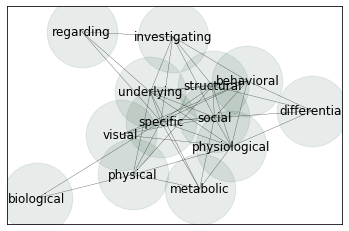

abstracts_0_cluster4_2018_200k_win2.model: specific -0.8816255451614738


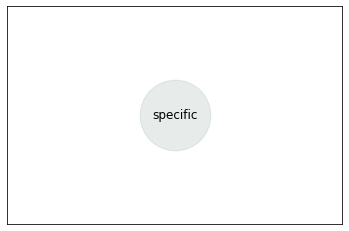

-----------------------------------
[('theoretical', -0.9574708879083538), ('throughout', -0.8929266143943237), ('programs', -0.88637238856571)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: theoretical -0.9574708879083538


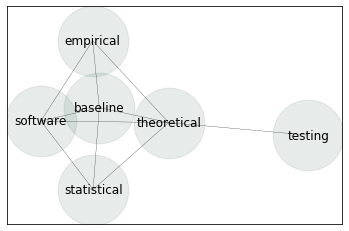

abstracts_0_cluster5_2018_200k_win2.model: theoretical -0.9574708879083538


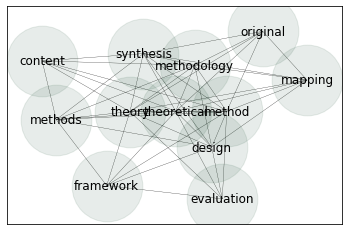

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: throughout -0.8929266143943237


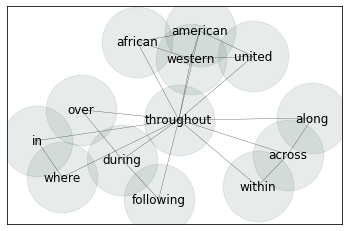

abstracts_0_cluster5_2018_200k_win2.model: throughout -0.8929266143943237


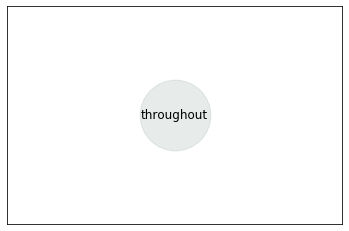

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: programs -0.88637238856571


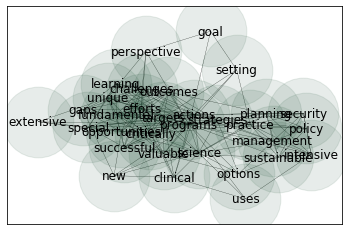

abstracts_0_cluster5_2018_200k_win2.model: programs -0.88637238856571


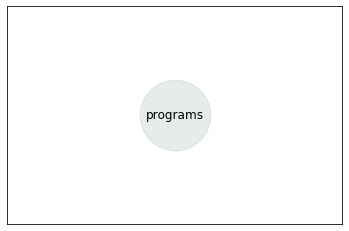

-----------------------------------
[('new', -0.9835424405874875), ('persistent', -0.9357923433236288), ('regression', -0.9340558871292459)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: new -0.9835424405874875


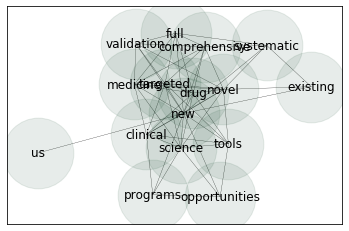

abstracts_0_cluster6_2018_200k_win2.model: new -0.9835424405874875


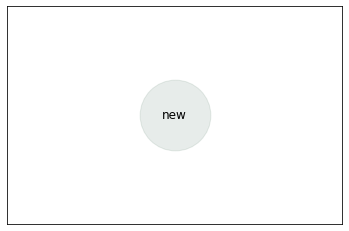

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: persistent -0.9357923433236288


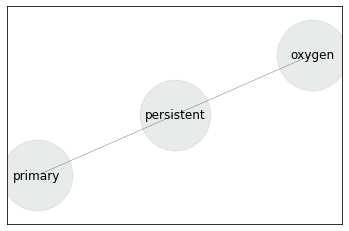

abstracts_0_cluster6_2018_200k_win2.model: persistent -0.9357923433236288


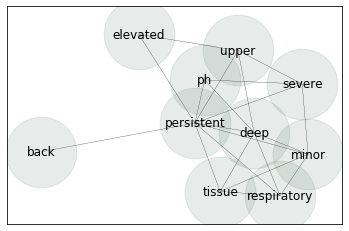

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: regression -0.9340558871292459


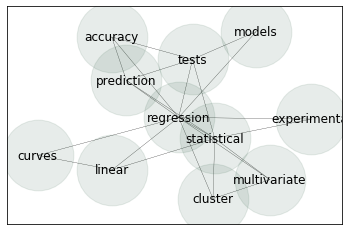

abstracts_0_cluster6_2018_200k_win2.model: regression -0.9340558871292459


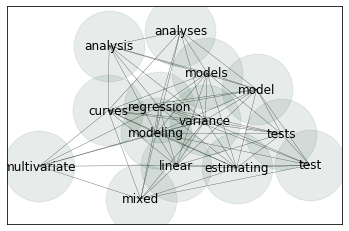

-----------------------------------
[('virus', -0.9965481986513458), ('finally', -0.9707079323200802), ('active', -0.9289139288782702)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: virus -0.9965481986513458


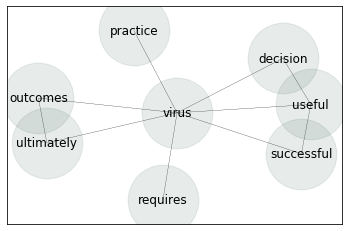

abstracts_0_cluster7_2018_200k_win2.model: virus -0.9965481986513458


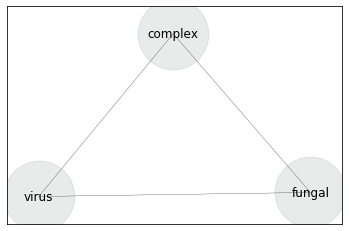

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: finally -0.9707079323200802


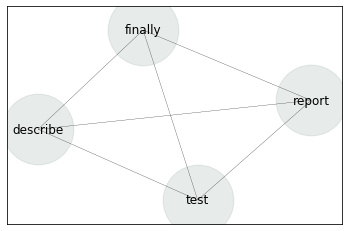

abstracts_0_cluster7_2018_200k_win2.model: finally -0.9707079323200802


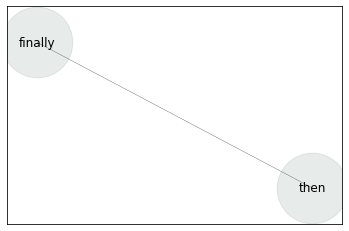

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: active -0.9289139288782702


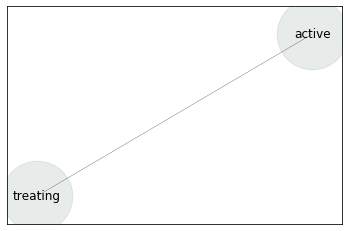

abstracts_0_cluster7_2018_200k_win2.model: active -0.9289139288782702


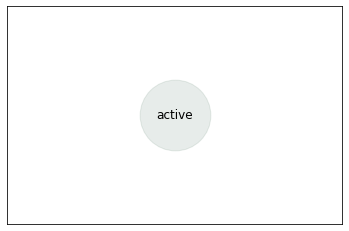

-----------------------------------
[('point', -0.9968626207420193), ('given', -0.9821904374996842), ('particularly', -0.9786361519675917)]
model names: 
abstracts_0_cluster2_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster2_2018_200k_win2.model: point -0.9968626207420193


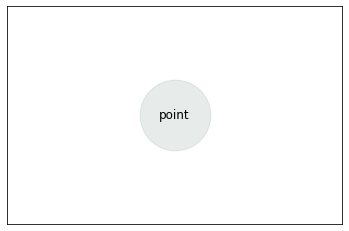

abstracts_0_cluster8_2018_200k_win2.model: point -0.9968626207420193


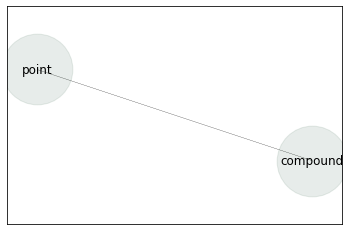

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: given -0.9821904374996842


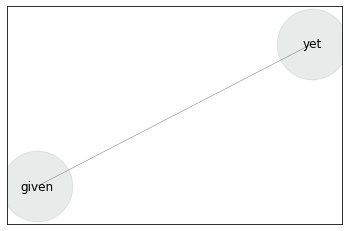

abstracts_0_cluster8_2018_200k_win2.model: given -0.9821904374996842


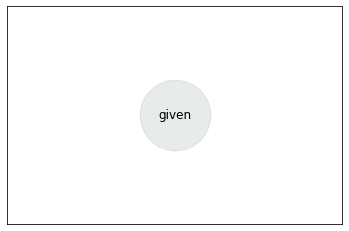

-----------------------------------
abstracts_0_cluster2_2018_200k_win2.model: particularly -0.9786361519675917


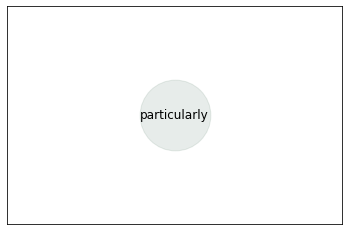

abstracts_0_cluster8_2018_200k_win2.model: particularly -0.9786361519675917


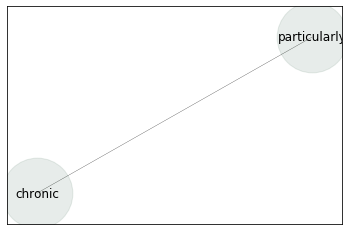

-----------------------------------
[('method', -0.9833904803751379), ('read', -0.9796004637753906), ('healthy', -0.9584630343568896)]
model names: 
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster4_2018_200k_win2.model

abstracts_0_cluster3_2018_200k_win2.model: method -0.9833904803751379


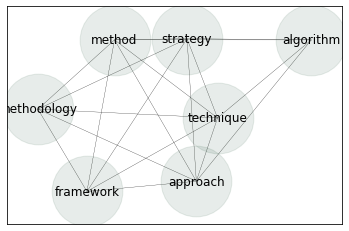

abstracts_0_cluster4_2018_200k_win2.model: method -0.9833904803751379


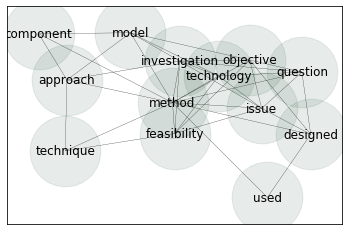

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: read -0.9796004637753906


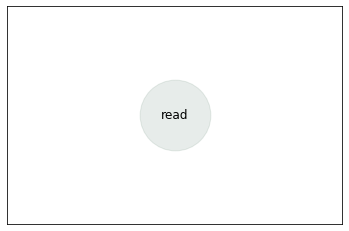

abstracts_0_cluster4_2018_200k_win2.model: read -0.9796004637753906


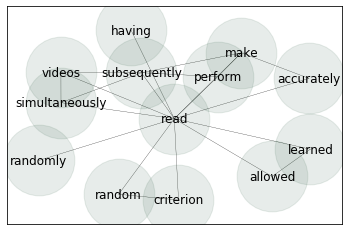

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: healthy -0.9584630343568896


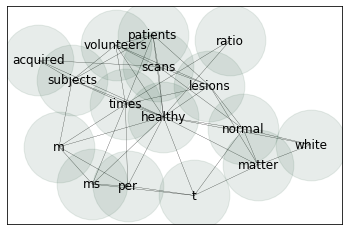

abstracts_0_cluster4_2018_200k_win2.model: healthy -0.9584630343568896


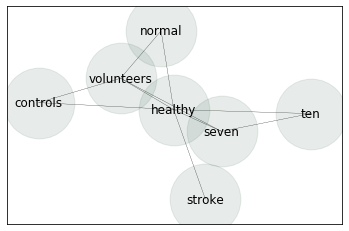

-----------------------------------
[('base', -0.9996807555666167), ('mortality', -0.9984030033673581), ('factors', -0.9964049336002465)]
model names: 
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model

abstracts_0_cluster3_2018_200k_win2.model: base -0.9996807555666167


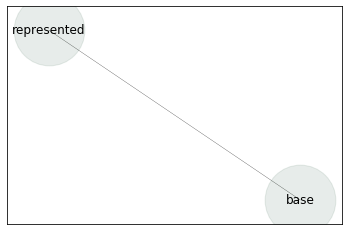

abstracts_0_cluster5_2018_200k_win2.model: base -0.9996807555666167


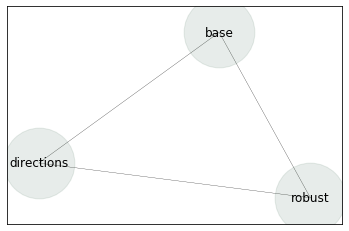

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: mortality -0.9984030033673581


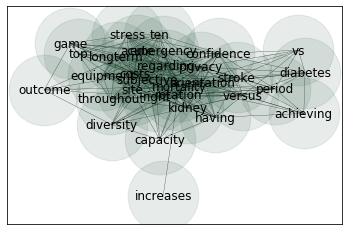

abstracts_0_cluster5_2018_200k_win2.model: mortality -0.9984030033673581


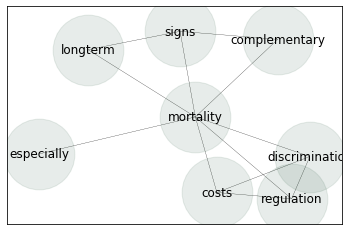

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: factors -0.9964049336002465


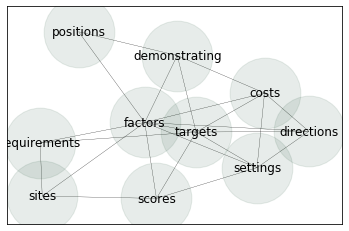

abstracts_0_cluster5_2018_200k_win2.model: factors -0.9964049336002465


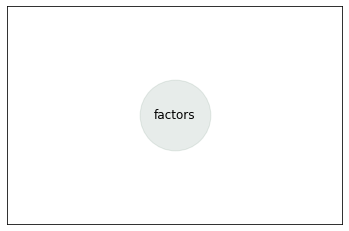

-----------------------------------
[('long', -0.9976785602776874), ('factors', -0.9893354273250985), ('gain', -0.981846597852531)]
model names: 
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster3_2018_200k_win2.model: long -0.9976785602776874


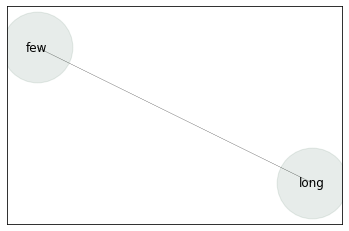

abstracts_0_cluster6_2018_200k_win2.model: long -0.9976785602776874


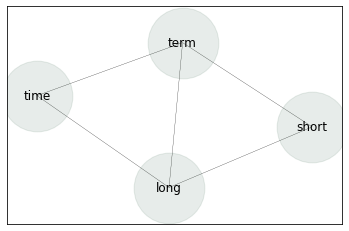

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: factors -0.9893354273250985


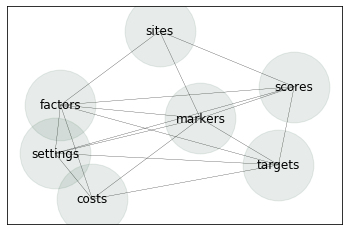

abstracts_0_cluster6_2018_200k_win2.model: factors -0.9893354273250985


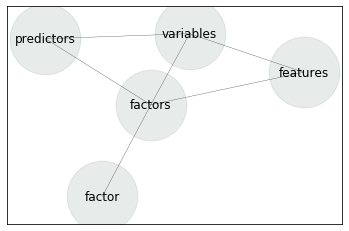

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: gain -0.981846597852531


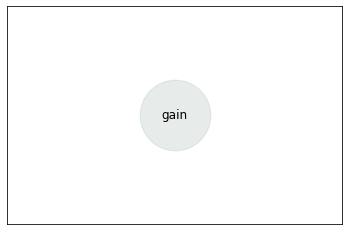

abstracts_0_cluster6_2018_200k_win2.model: gain -0.981846597852531


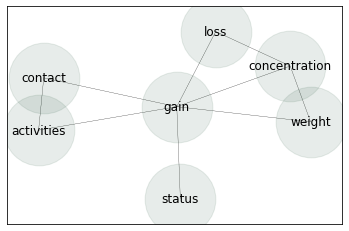

-----------------------------------
[('al', -0.9742552607469537), ('node', -0.9703096381833141), ('management', -0.9573837747445317)]
model names: 
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster3_2018_200k_win2.model: al -0.9742552607469537


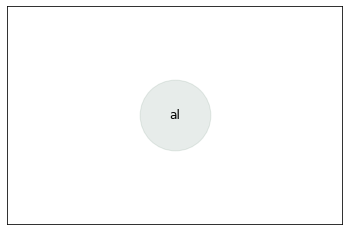

abstracts_0_cluster7_2018_200k_win2.model: al -0.9742552607469537


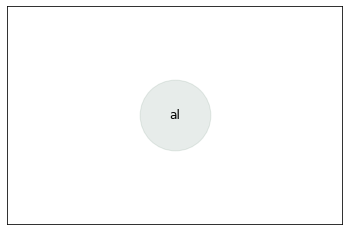

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: node -0.9703096381833141


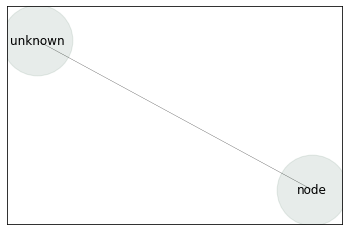

abstracts_0_cluster7_2018_200k_win2.model: node -0.9703096381833141


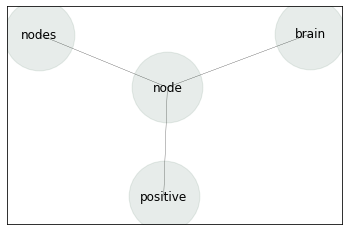

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: management -0.9573837747445317


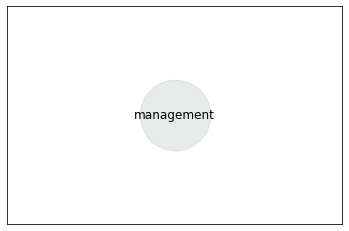

abstracts_0_cluster7_2018_200k_win2.model: management -0.9573837747445317


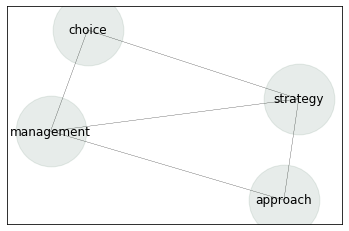

-----------------------------------
[('biology', -0.9731401587686115), ('methods', -0.9623614420158739), ('quantify', -0.9257190604512995)]
model names: 
abstracts_0_cluster3_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster3_2018_200k_win2.model: biology -0.9731401587686115


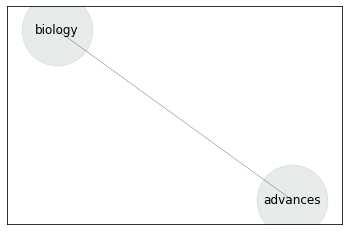

abstracts_0_cluster8_2018_200k_win2.model: biology -0.9731401587686115


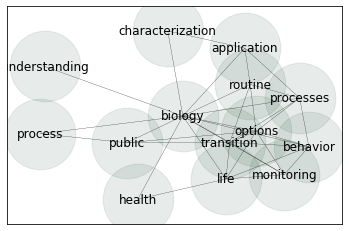

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: methods -0.9623614420158739


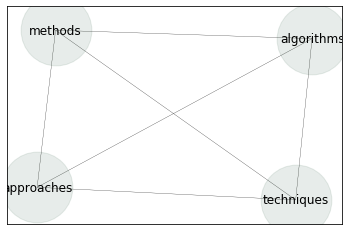

abstracts_0_cluster8_2018_200k_win2.model: methods -0.9623614420158739


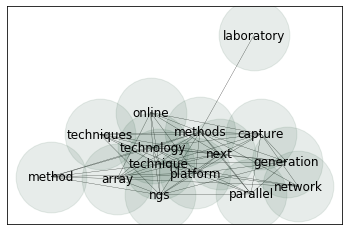

-----------------------------------
abstracts_0_cluster3_2018_200k_win2.model: quantify -0.9257190604512995


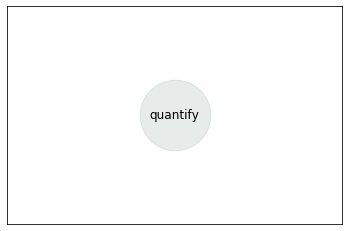

abstracts_0_cluster8_2018_200k_win2.model: quantify -0.9257190604512995


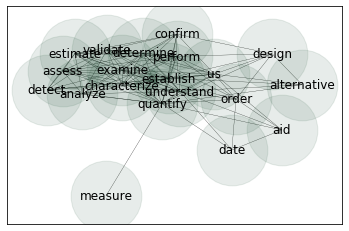

-----------------------------------
[('every', -0.9953087918220491), ('critically', -0.9593849059400079), ('reliable', -0.9555579635286828)]
model names: 
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster5_2018_200k_win2.model

abstracts_0_cluster4_2018_200k_win2.model: every -0.9953087918220491


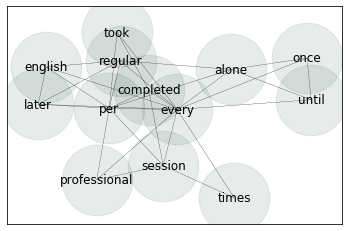

abstracts_0_cluster5_2018_200k_win2.model: every -0.9953087918220491


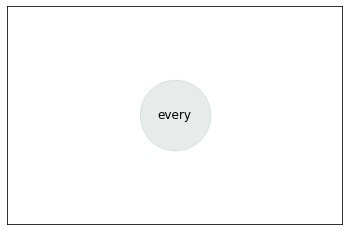

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: critically -0.9593849059400079


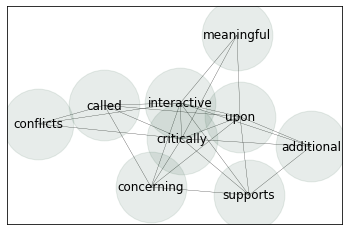

abstracts_0_cluster5_2018_200k_win2.model: critically -0.9593849059400079


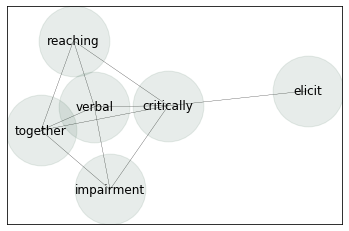

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: reliable -0.9555579635286828


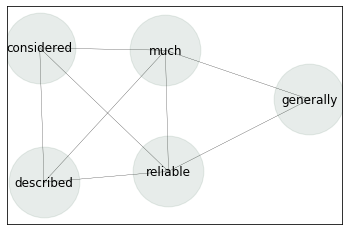

abstracts_0_cluster5_2018_200k_win2.model: reliable -0.9555579635286828


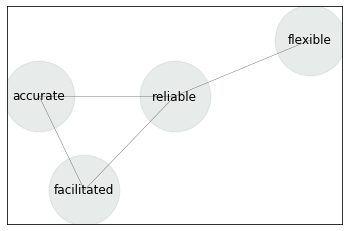

-----------------------------------
[('controlled', -0.9660340326837464), ('laboratory', -0.847360639133174), ('term', -0.8245618056300739)]
model names: 
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster4_2018_200k_win2.model: controlled -0.9660340326837464


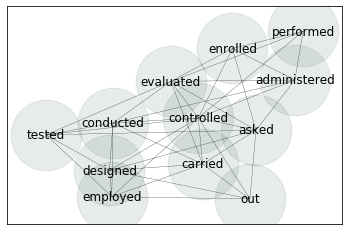

abstracts_0_cluster6_2018_200k_win2.model: controlled -0.9660340326837464


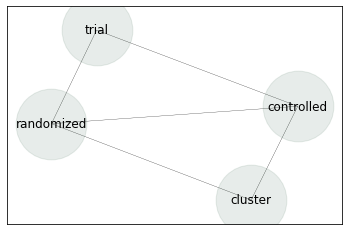

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: laboratory -0.847360639133174


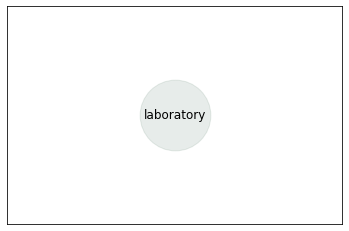

abstracts_0_cluster6_2018_200k_win2.model: laboratory -0.847360639133174


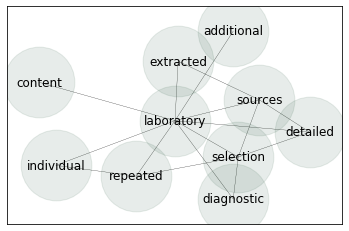

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: term -0.8245618056300739


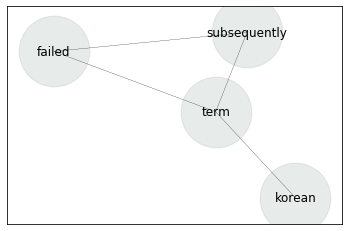

abstracts_0_cluster6_2018_200k_win2.model: term -0.8245618056300739


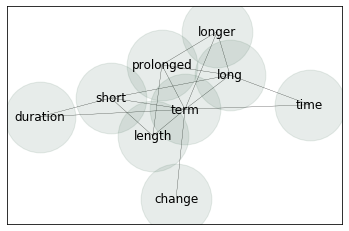

-----------------------------------
[('findings', -0.973867006429382), ('reaction', -0.9653916072380699), ('comparing', -0.9492635039912622)]
model names: 
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster4_2018_200k_win2.model: findings -0.973867006429382


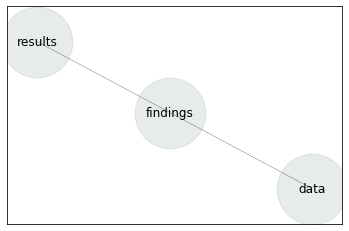

abstracts_0_cluster7_2018_200k_win2.model: findings -0.973867006429382


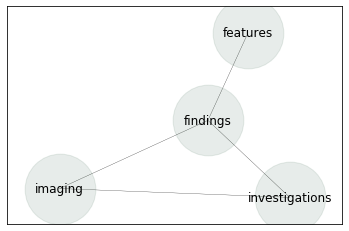

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: reaction -0.9653916072380699


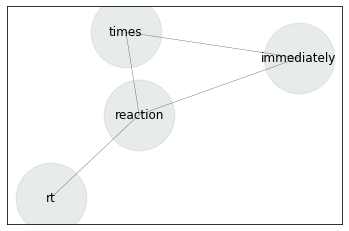

abstracts_0_cluster7_2018_200k_win2.model: reaction -0.9653916072380699


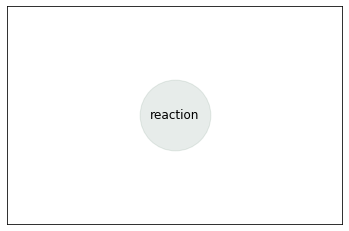

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: comparing -0.9492635039912622


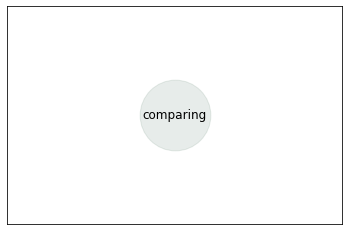

abstracts_0_cluster7_2018_200k_win2.model: comparing -0.9492635039912622


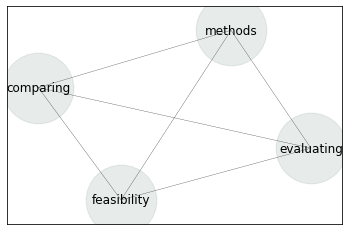

-----------------------------------
[('extent', -0.979718329254849), ('capture', -0.9719425905794901), ('manner', -0.9690397611095367)]
model names: 
abstracts_0_cluster4_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster4_2018_200k_win2.model: extent -0.979718329254849


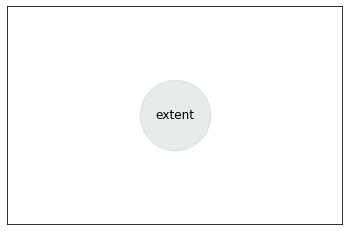

abstracts_0_cluster8_2018_200k_win2.model: extent -0.979718329254849


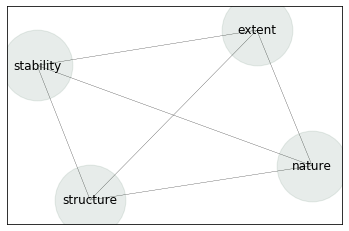

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: capture -0.9719425905794901


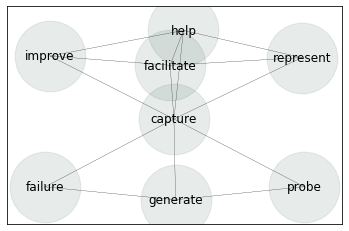

abstracts_0_cluster8_2018_200k_win2.model: capture -0.9719425905794901


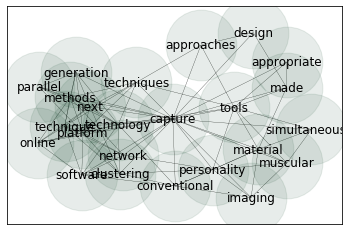

-----------------------------------
abstracts_0_cluster4_2018_200k_win2.model: manner -0.9690397611095367


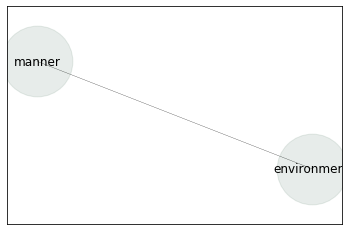

abstracts_0_cluster8_2018_200k_win2.model: manner -0.9690397611095367


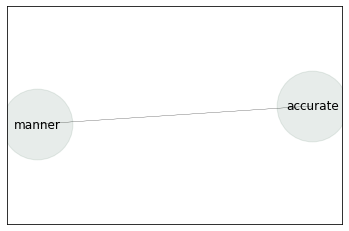

-----------------------------------
[('simple', -0.9907102101587688), ('examining', -0.975367546990419), ('confidence', -0.9541733738404028)]
model names: 
abstracts_0_cluster5_2018_200k_win2.model
abstracts_0_cluster6_2018_200k_win2.model

abstracts_0_cluster5_2018_200k_win2.model: simple -0.9907102101587688


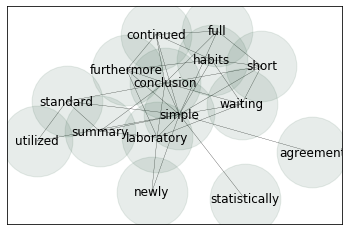

abstracts_0_cluster6_2018_200k_win2.model: simple -0.9907102101587688


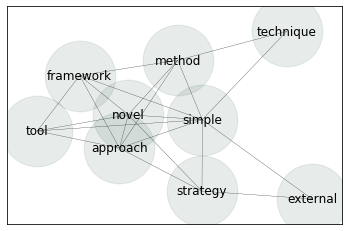

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: examining -0.975367546990419


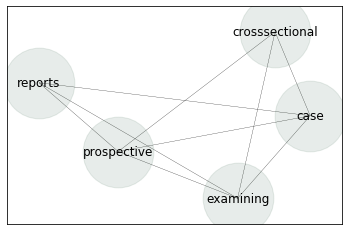

abstracts_0_cluster6_2018_200k_win2.model: examining -0.975367546990419


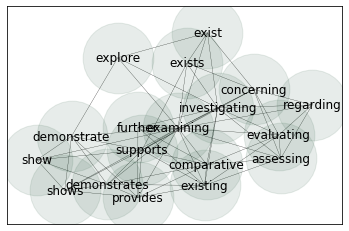

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: confidence -0.9541733738404028


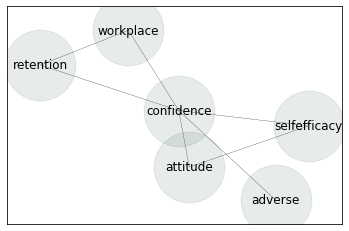

abstracts_0_cluster6_2018_200k_win2.model: confidence -0.9541733738404028


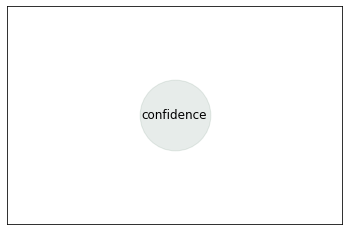

-----------------------------------
[('treating', -0.9720006505365841), ('face', -0.9519893726494759), ('causes', -0.9124595754609572)]
model names: 
abstracts_0_cluster5_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster5_2018_200k_win2.model: treating -0.9720006505365841


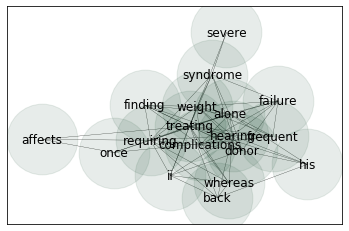

abstracts_0_cluster7_2018_200k_win2.model: treating -0.9720006505365841


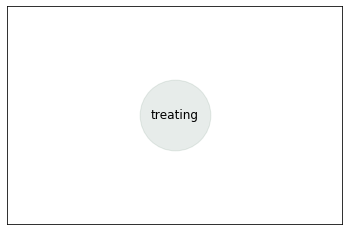

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: face -0.9519893726494759


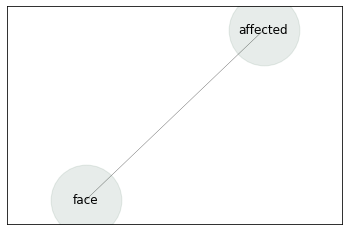

abstracts_0_cluster7_2018_200k_win2.model: face -0.9519893726494759


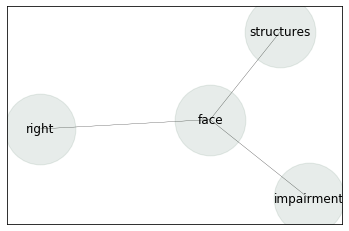

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: causes -0.9124595754609572


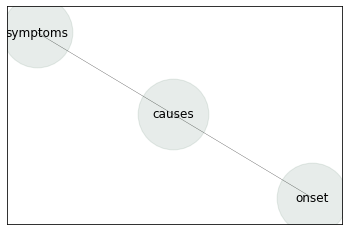

abstracts_0_cluster7_2018_200k_win2.model: causes -0.9124595754609572


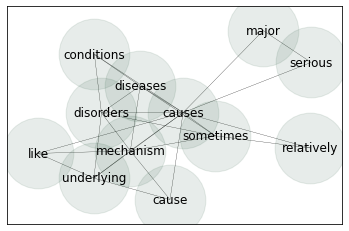

-----------------------------------
[('enhanced', -0.9603827269112748), ('pathway', -0.9390838900880931), ('reliable', -0.9303450161885118)]
model names: 
abstracts_0_cluster5_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster5_2018_200k_win2.model: enhanced -0.9603827269112748


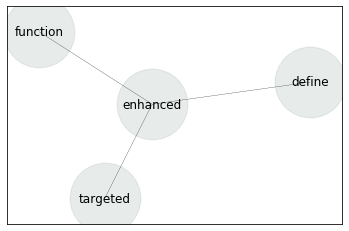

abstracts_0_cluster8_2018_200k_win2.model: enhanced -0.9603827269112748


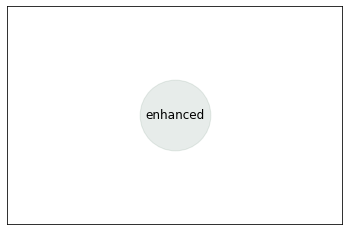

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: pathway -0.9390838900880931


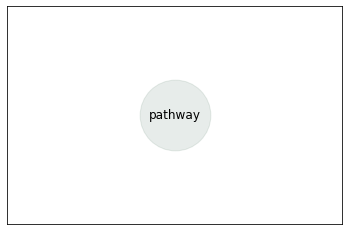

abstracts_0_cluster8_2018_200k_win2.model: pathway -0.9390838900880931


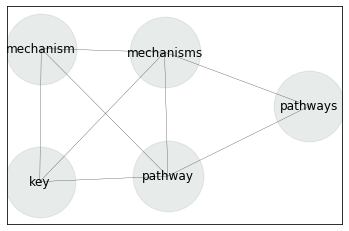

-----------------------------------
abstracts_0_cluster5_2018_200k_win2.model: reliable -0.9303450161885118


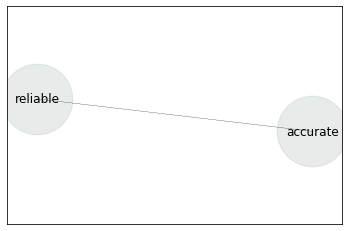

abstracts_0_cluster8_2018_200k_win2.model: reliable -0.9303450161885118


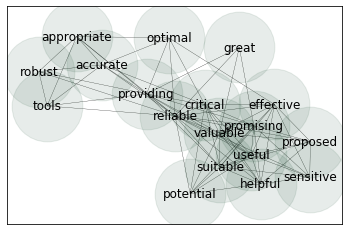

-----------------------------------
[('mixed', -0.9841268514340369), ('standard', -0.9808963316279775), ('repeated', -0.8805614018699888)]
model names: 
abstracts_0_cluster6_2018_200k_win2.model
abstracts_0_cluster7_2018_200k_win2.model

abstracts_0_cluster6_2018_200k_win2.model: mixed -0.9841268514340369


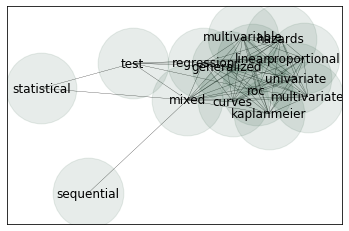

abstracts_0_cluster7_2018_200k_win2.model: mixed -0.9841268514340369


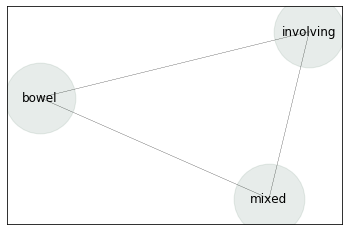

-----------------------------------
abstracts_0_cluster6_2018_200k_win2.model: standard -0.9808963316279775


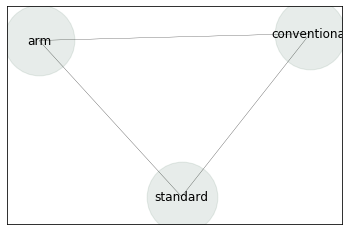

abstracts_0_cluster7_2018_200k_win2.model: standard -0.9808963316279775


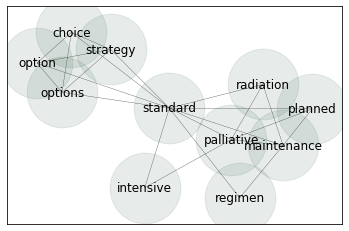

-----------------------------------
abstracts_0_cluster6_2018_200k_win2.model: repeated -0.8805614018699888


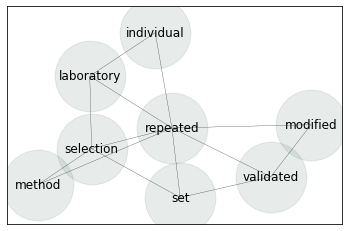

abstracts_0_cluster7_2018_200k_win2.model: repeated -0.8805614018699888


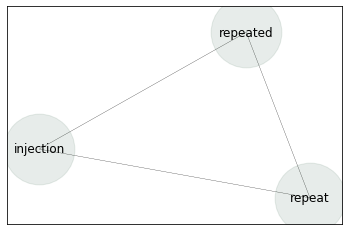

-----------------------------------
[('sclerosis', -0.9804263472120667), ('mainly', -0.9628614613423976), ('point', -0.9246994914690467)]
model names: 
abstracts_0_cluster6_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster6_2018_200k_win2.model: sclerosis -0.9804263472120667


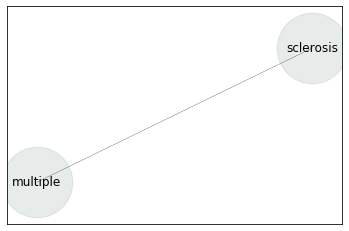

abstracts_0_cluster8_2018_200k_win2.model: sclerosis -0.9804263472120667


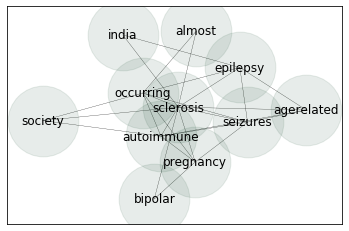

-----------------------------------
abstracts_0_cluster6_2018_200k_win2.model: mainly -0.9628614613423976


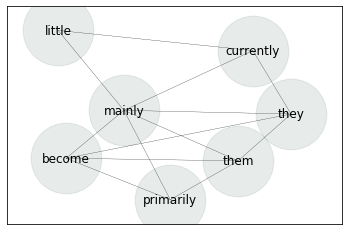

abstracts_0_cluster8_2018_200k_win2.model: mainly -0.9628614613423976


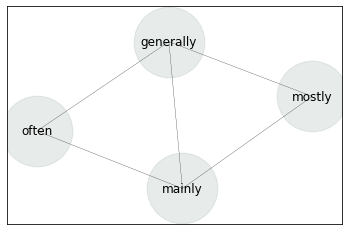

-----------------------------------
abstracts_0_cluster6_2018_200k_win2.model: point -0.9246994914690467


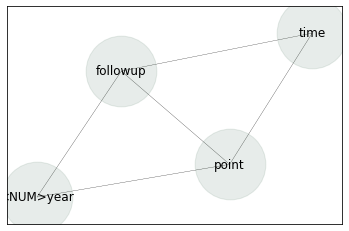

abstracts_0_cluster8_2018_200k_win2.model: point -0.9246994914690467


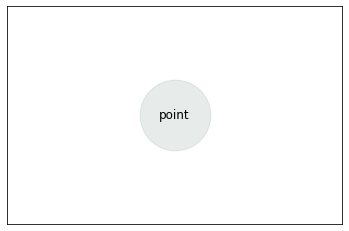

-----------------------------------
[('involved', -0.992946964963684), ('lines', -0.9474360954273724), ('major', -0.9278557828997493)]
model names: 
abstracts_0_cluster7_2018_200k_win2.model
abstracts_0_cluster8_2018_200k_win2.model

abstracts_0_cluster7_2018_200k_win2.model: involved -0.992946964963684


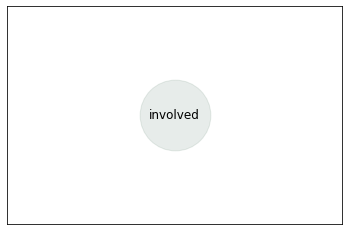

abstracts_0_cluster8_2018_200k_win2.model: involved -0.992946964963684


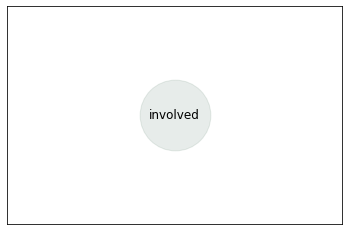

-----------------------------------
abstracts_0_cluster7_2018_200k_win2.model: lines -0.9474360954273724


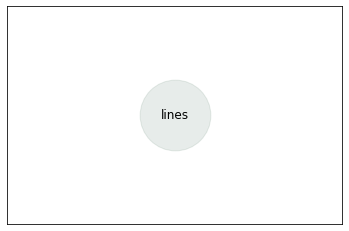

abstracts_0_cluster8_2018_200k_win2.model: lines -0.9474360954273724


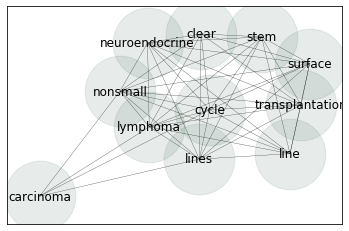

-----------------------------------
abstracts_0_cluster7_2018_200k_win2.model: major -0.9278557828997493


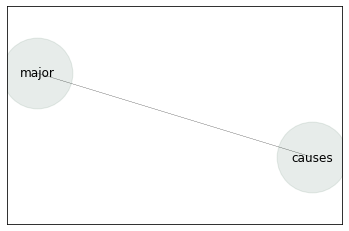

abstracts_0_cluster8_2018_200k_win2.model: major -0.9278557828997493


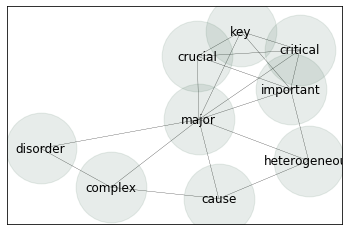

-----------------------------------


In [34]:
i_sample = 0

# for each comparison, print most different words
comparisons = CCA_comparisons[i_sample]
for i_comparison, comparison in enumerate(comparisons):
    
    shared_vocab = comparison['shared_vocab']
    pairs = zip(comparison['word_similarities'],
                comparison['shared_vocab'])
    worst_to_best = [(word,score) for score,word in sorted(pairs)]
    topK = 3  # K topworst words
    topworst = worst_to_best[:topK][:]
    print(topworst)
    
    # print networkx neighbors for each model
    print('model names: ')
    print(comparison['modelA'])
    print(comparison['modelB'])
    print()
    
    for i_pair, pair in enumerate(topworst):   # pair := (word, score)
        
        word = pair[0]
        
        modelA = comparison['modelA']
        node_ID = node_names[modelA][word]
        print('{}: {} {}'.format(modelA, word, pair[1]))
        shared_vocab_IDs = [node_names[modelA][w] for w in shared_vocab]
        G_a = nx_graphs[modelA].subgraph(shared_vocab_IDs)
        plot_ego_graph(G_a, node_ID)
        
        modelB = comparison['modelB']
        node_ID = node_names[modelB][word]
        print('{}: {} {}'.format(modelB, word, pair[1]))
        shared_vocab_IDs = [node_names[modelB][w] for w in shared_vocab]
        G_b = nx_graphs[modelB].subgraph(shared_vocab_IDs) # restrict to shared vocabulary
        plot_ego_graph(G_b, node_ID)
    
        print('-----------------------------------')
    
# todo investigate this in the context of centrality

In [31]:

# todo plot local w2v neighborhood


# get network for each world


# take local neighborhood of top words

In [32]:
### plot aggregate CCA correlation level plots


#  bbox_inches = "tight"   # note

# other option - left_margin = 15mm, right_margin = 15mm)




# todo check 2018_200k_